# Introduction


This notebook is all about experimenting and understanding how different model architectures perform when paired with various functions, optimizers, and loss functions — especially in the context of a real-world churn prediction task.

While I was curious to see which models performed best, my main focus was on learning how each architectural and optimization choice impacted key evaluation metrics like precision, recall, and F1 score — instead of just chasing accuracy.

**What I did:**

* Built 7 different ANN architectures, each with their own variations.

* Experimented with 6 widely-used optimizers (like Adam, SGD, Adagrad, etc.) across these architectures.

* Tuned models multiple times to bring out the best performance.

* Used two loss functions: Binary Cross Entropy (BCELoss) and Binary Cross Entropy with Logits (BCEWithLogitsLoss).

* Trained and tuned 8 classical machine learning models for comparison.

* In total, I tested 42 deep learning models and 8 ML models.

**What I learned:**

This project helped me deeply understand the trade-offs between precision, recall, and F1, and why accuracy alone isn’t enough, especially with imbalanced data like customer churn.


>I structured the notebook this way mainly for my own clarity and sanity. With so many models, experiments, and tuning combinations, it would’ve been a mess if I didn’t modularize it.
Hiding some of the repetitive code and using dropdowns helped me focus on the results and insights rather than scrolling through a wall of code.
This was was just my way of staying organized and making sure I could come back later and understand what I did, why I did it, and what worked.

# Imports

In [24]:
import torch
from torch import nn
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import torch.optim as optim

In [25]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)

# Basic Data analysis

In [26]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [27]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [28]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [29]:
df['Churn'].value_counts(normalize = False)

,count
Churn,
No,5174
Yes,1869


In [30]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

In [31]:
df['PaperlessBilling'].value_counts(normalize = False)

,count
PaperlessBilling,
Yes,4168
No,2864


In [32]:
df['gender'].value_counts(normalize = False) # 0 x

,count
gender,
Male,3549
Female,3483


In [33]:
df['InternetService'].value_counts(normalize=False) # 7

,count
InternetService,
Fiber optic,3096
DSL,2416
No,1520


In [34]:
df['MultipleLines'].value_counts(normalize=False) # 6

,count
MultipleLines,
No,3385
Yes,2967
No phone service,680


In [35]:
df['Contract'].value_counts(normalize = False)# 14

,count
Contract,
Month-to-month,3875
Two year,1685
One year,1472


In [36]:
df['PaymentMethod'].value_counts(normalize = False) # 16

,count
PaymentMethod,
Electronic check,2365
Mailed check,1604
Bank transfer (automatic),1542
Credit card (automatic),1521


In [37]:
df['TotalCharges'].isnull().sum()

np.int64(0)

# Data Visualization and further analysis

<ipython-input-38-2653566854>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', palette='pastel', edgecolor='black')


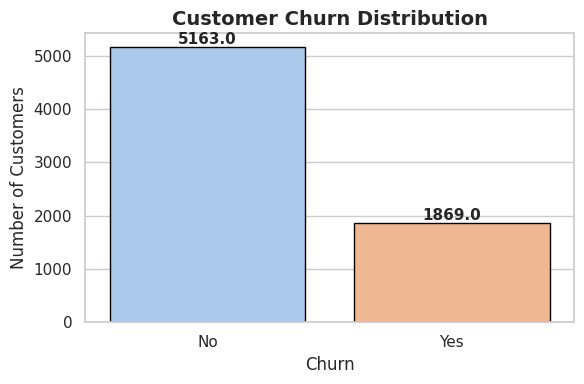

In [38]:
# @title
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='Churn', palette='pastel', edgecolor='black')

# Add title and labels
plt.title("Customer Churn Distribution", fontsize=14, weight='bold')
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

>~36 % churn Rate

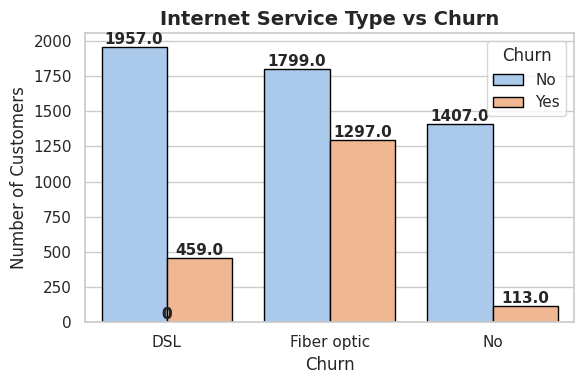

In [39]:
# @title
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='InternetService', hue='Churn', palette='pastel', edgecolor='black')

plt.title("Internet Service Type vs Churn", fontsize = 14, weight = 'bold')
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

>Fiber optic customers tend to churn more. Maybe due to higher prices or technical issues.

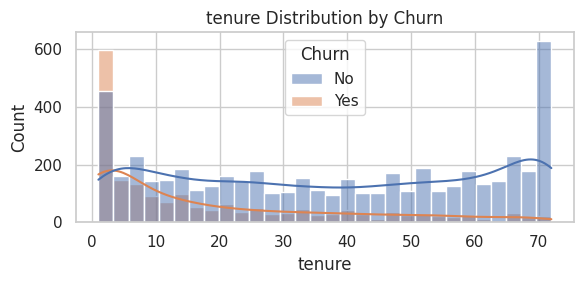

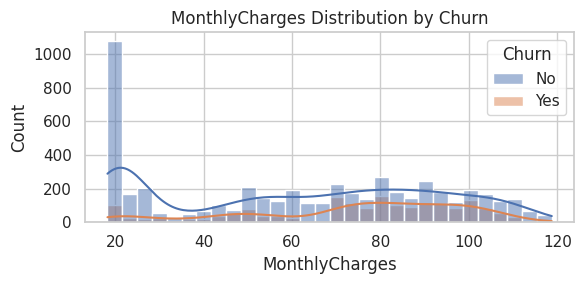

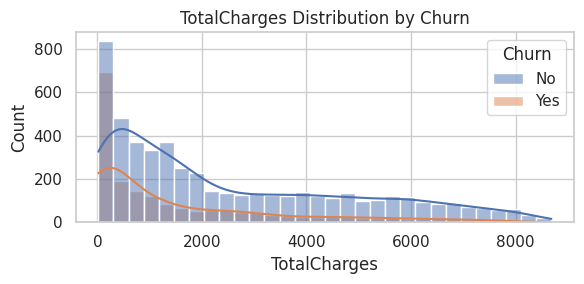

In [40]:
# @title
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f"{col} Distribution by Churn")
    plt.tight_layout()
    plt.show()

>Tenure can affect churn. Short tenure can increase risk of churn (3 - 6 months). Long tenure = Lower churn risk

>Higher charges are associated with higher churn. Expense plans can push customers away.

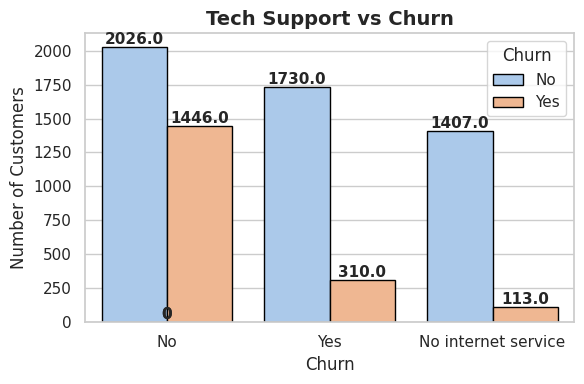

In [41]:
# @title
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='TechSupport', hue = 'Churn', palette='pastel', edgecolor='black')

plt.title("Tech Support vs Churn", fontsize=14, weight='bold')
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


>Customers without tech support are more likely to churn. This can be used to design retention offers.

Text(0.5, 1.0, 'Correlation Heatmap')

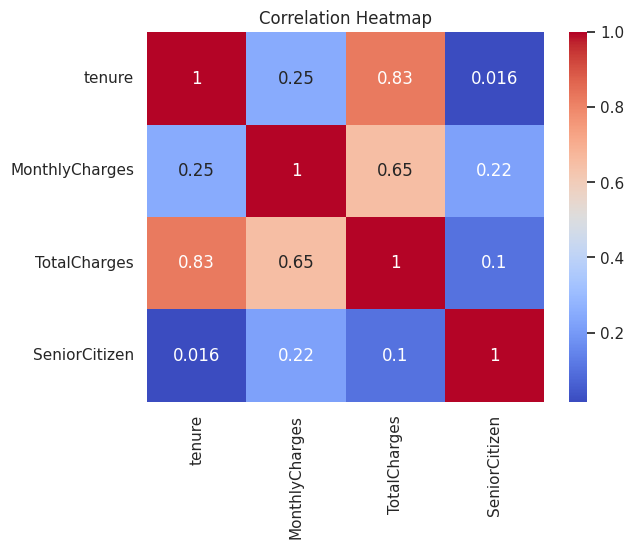

In [42]:
# @title
corr = df[num_cols + ['SeniorCitizen']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")


# Splitting and preparing the Data

In [43]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1].values

In [44]:
le = LabelEncoder()
y = le.fit_transform(y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [46]:
# Encoding Categorical and Labeled data
categorical_data = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
label_encoding_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_data),
                                     ('ordinal', OrdinalEncoder(), label_encoding_cols),
                                     ('num', StandardScaler(), numeric_cols)], remainder = "passthrough")

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [47]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [48]:
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)

In [49]:
X_train.shape

torch.Size([8250, 28])

# Models


In [50]:
X_train.shape[1]

28

In [51]:
class ChurnModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.relu1 = nn.ReLU()

    self.layer_2 = nn.Linear(128, 64)
    self.relu2 = nn.ReLU()

    self.layer_3 = nn.Linear(64, 32)
    self.relu3 = nn.ReLU()

    self.layer_4 = nn.Linear(32, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu1(self.layer_1(x))
    x = self.relu2(self.layer_2(x))
    x = self.relu3(self.layer_3(x))
    x = self.layer_4(x)
    return x

In [52]:
class ChurnModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.3)

    self.layer_2 = nn.Linear(128, 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.3)

    self.layer_3 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.dropout1(self.relu1(self.batchnorm1(self.layer_1(x))))
    x = self.dropout2(self.relu2(self.batchnorm2(self.layer_2(x))))
    x = self.layer_3(x)
    return x

In [53]:
class ChurnModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 64)
    self.relu1 = nn.ReLU()

    self.layer_2 = nn.Linear(64, 64)
    self.relu2 = nn.ReLU()

    self.layer_3 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu1(self.layer_1(x))
    x = self.relu2(self.layer_2(x))
    x = self.sigmoid(self.layer_3(x))
    return x

In [54]:
class ChurnModelV4(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.layer_2 = nn.Linear(128, 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.3)

    self.layer_3 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.dropout1(self.relu1(self.batchnorm1(self.layer_1(x))))
    x = self.dropout2(self.relu2(self.batchnorm2(self.layer_2(x))))
    x = self.sigmoid(self.layer_3(x))
    return x

In [55]:
class ChurnModelV5(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.LeakyRelu1 = nn.LeakyReLU(negative_slope=0.01)

    self.layer_2 = nn.Linear(128, 64)
    self.LeakyRelu2 = nn.LeakyReLU(negative_slope=0.01)

    self.layer_3 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.LeakyRelu1(self.layer_1(x))
    x = self.LeakyRelu2(self.layer_2(x))
    x = self.layer_3(x)
    return x

In [56]:
class ChurnModelV6(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.relu1 = nn.LeakyReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.layer_2 = nn.Linear(128, 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.relu2 = nn.LeakyReLU()
    self.dropout2 = nn.Dropout(p=0.3)

    self.layer_3 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.dropout1(self.relu1(self.batchnorm1(self.layer_1(x))))
    x = self.dropout2(self.relu2(self.batchnorm2(self.layer_2(x))))
    x = self.sigmoid(self.layer_3(x))
    return x

In [57]:
class ChurnModelV7(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(28, 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.relu1 = nn.LeakyReLU()
    self.dropout1 = nn.Dropout(p=0.3)

    self.layer_2 = nn.Linear(128, 128)
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.relu2 = nn.LeakyReLU()
    self.dropout2 = nn.Dropout(p=0.4)

    self.layer_3 = nn.Linear(128, 64)
    self.batchnorm3 = nn.BatchNorm1d(64)
    self.relu3 = nn.LeakyReLU()
    self.dropout3 = nn.Dropout(p=0.3)

    self.layer_4 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.dropout1(self.relu1(self.batchnorm1(self.layer_1(x))))
    x = self.dropout2(self.relu2(self.batchnorm2(self.layer_2(x))))
    x = self.dropout3(self.relu3(self.batchnorm3(self.layer_3(x))))
    x = self.layer_4(x)
    return x

In [58]:
model_1 = ChurnModel()
model_2 = ChurnModelV2()
model_3 = ChurnModelV3() # Sigmoid
model_4 = ChurnModelV4() # Sigmoid
model_5 = ChurnModelV5()
model_6 = ChurnModelV6() # Sigmoid
model_7 = ChurnModelV7()

# Initial Training set Accuracies


Initial model accuracy : 44.3394 %



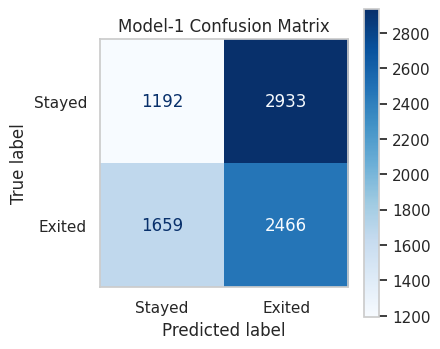

In [59]:
# MODEL 1
with torch.inference_mode():
  y_pred = model_1(X_train)
  y_pred_probs = torch.sigmoid(y_pred)
  y_labels = torch.round(y_pred_probs)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_1 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-1 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 50.3636 %



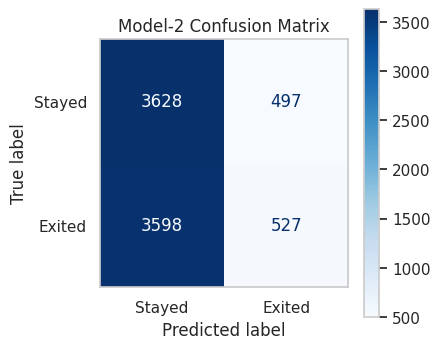

In [60]:
# MODEL 2
with torch.inference_mode():
  y_pred = model_2(X_train)
  y_pred_probs = torch.sigmoid(y_pred)
  y_labels = torch.round(y_pred_probs)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_2 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-2 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 50.0000 %



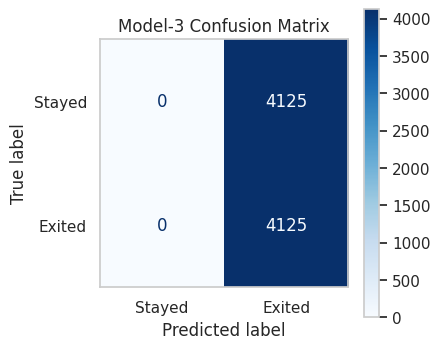

In [61]:
# MODEL 3
with torch.inference_mode():
  y_pred = model_3(X_train)
  y_labels = torch.round(y_pred)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_3 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-3 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 40.9455 %



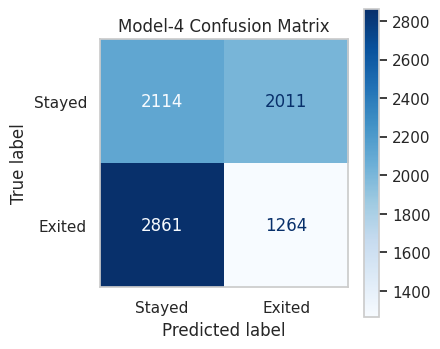

In [62]:
# MODEL 4
with torch.inference_mode():
  y_pred = model_4(X_train)
  y_labels = torch.round(y_pred)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_4 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-4 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 58.3030 %



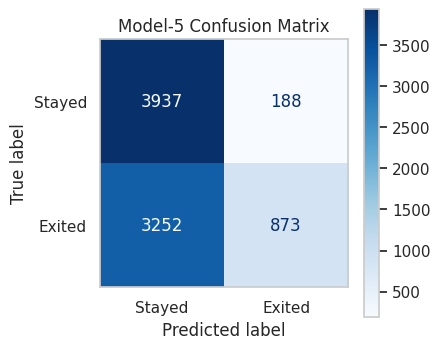

In [63]:
# MODEL 5
with torch.inference_mode():
  y_pred = model_5(X_train)
  y_pred_probs = torch.sigmoid(y_pred)
  y_labels = torch.round(y_pred_probs)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_5 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-5 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 54.7515 %



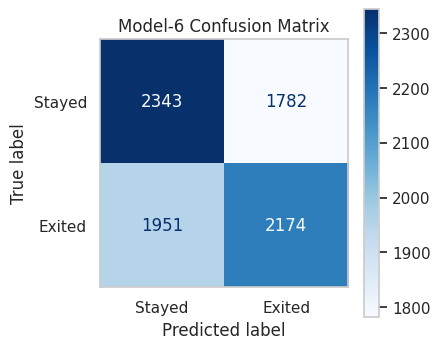

In [64]:
# MODEL 6
with torch.inference_mode():
  y_pred = model_6(X_train)
  y_labels = torch.round(y_pred)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")

cm_6 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_6, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-6 Confusion Matrix")
plt.grid(False)
plt.show()

Initial model accuracy : 44.3394 %



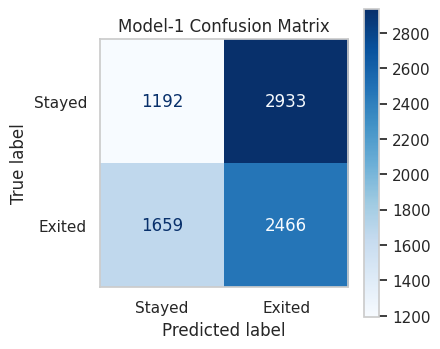

In [65]:
# MODEL 7
with torch.inference_mode():
  y_pred = model_1(X_train)
  y_pred_probs = torch.sigmoid(y_pred)
  y_labels = torch.round(y_pred_probs)

print(f"Initial model accuracy : {accuracy_score(y_train, y_labels) * 100:.4f} %\n")
cm_1 = confusion_matrix(y_train, y_labels)

fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=["Stayed", "Exited"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Model-1 Confusion Matrix")
plt.grid(False)
plt.show()

# Optimizer and Loss Functions

In [66]:
pos_weight = torch.tensor([5163 / 1869])  # 2.27
# pos_weight=pos_weight

In [67]:
loss_fn_1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn_2 = nn.BCELoss()

# --- SGD ---
SGD_optim = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
             for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# --- Adam ---
Adam_optim = [optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
              for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# --- RMSprop ---
RMSprop_optim = [optim.RMSprop(model.parameters(), lr=0.0007, alpha=0.9, momentum=0.9)
                 for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# --- SGD with Momentum (SGDW) ---
SGDW_optim = [optim.SGD(model.parameters(), lr=0.001, momentum=0.95, nesterov=True, weight_decay=1e-4)
              for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# --- Adagrad ---
Adagrad_optim = [optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-4)
                 for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# --- AdamW ---
AdamW_optim = [optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
               for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7]]

# Training and Testing loops

In [68]:
# @title
SGD_precision_scores = []
SGD_f1_scores = []
SGD_recall_scores = []
SGD_accuracy_scores = []
SGD_ROC_scores =[]

adam_precision_scores = []
adam_f1_scores = []
adam_recall_scores = []
adam_accuracy_scores = []
adam_ROC_scores = []

rms_precision_scores = []
rms_f1_scores = []
rms_recall_scores = []
rms_accuracy_scores = []
rms_ROC_scores = []

SGDW_precision_scores = []
SGDW_f1_scores = []
SGDW_recall_scores = []
SGDW_accuracy_scores = []
SGDW_ROC_scores = []

adagrad_precision_scores = []
adagrad_f1_scores = []
adagrad_recall_scores = []
adagrad_accuracy_scores = []
adagrad_ROC_scores = []

adamW_precision_scores = []
adamW_recall_scores = []
adamW_f1_scores = []
adamW_accuracy_scores = []
adamW_ROC_scores = []

roc_curve_data = []

In [69]:
# @title
def model_loopV1(optimizer, loss_fn, model, precision, recall, f1, accuracy, model_name="", optimizer_name="", epochs=250, limit=100, plot = False, matrix = False, score_board = False, cf = False):
    print("______________________________________________________________________________________________________________________________________________________________________________________")
    best_accuracy = 0
    patience_counter = 0
    test_label = 0
    best_accuracy = 0

    epoch_counts = []
    test_loss_values = []
    train_loss_values = []
    test_accuracies = []
    threshold = 0.5

    for epoch in range(epochs):
        model.train()

        y_logits = model(X_train)
        y_pred_probs = torch.sigmoid(y_logits)
        y_labels = (y_pred_probs > threshold).int()

        loss = loss_fn(y_logits, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_pred_probs = torch.sigmoid(test_logits)
            test_labels = (test_pred_probs > threshold).int()

            test_loss = loss_fn(test_logits, y_test)
            test_accuracy = accuracy_score(y_test, test_labels)

            epoch_counts.append(epoch)
            test_loss_values.append(test_loss.item())
            train_loss_values.append(loss.item())
            test_accuracies.append(test_accuracy)

            # Early stopping
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                patience_counter = 0
            else:
                patience_counter += 1
            if score_board == True:

              if epoch % 10 == 0:
                  print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f}")

            if patience_counter >= limit:
                print(f"\n Early stopping at epoch {epoch} | no improvement in last {limit} epochs.")
                break

    print(f"\n Best accuracy: {best_accuracy * 100:.4f}")

    if plot == True:
      plt.figure(figsize=(10, 5))
      plt.plot(test_accuracies, label="Test Accuracy", color="green")
      plt.title(f"Test Accuracy over Epochs (Best: {best_accuracy * 100:.2f}) %")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend()
      plt.grid(True, alpha = 0.6)
      plt.show()

    if matrix == True:
      cm = confusion_matrix(y_test, test_labels)

      fig, ax = plt.subplots(figsize=(5, 5))

      disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Stayed", "Exited"])
      disp.plot(cmap = "Blues", ax = ax)
      ax.set_title(f"Confusion Matrix of {optimizer_name} with {model_name}")
      plt.grid(False)
      plt.show()

    if cf == True:
      print(classification_report(y_test, test_labels, target_names=["Stayed", "Exited"]))

      test_pred_probs_np = test_pred_probs.detach().cpu().numpy()
      y_test_np = y_test.cpu().numpy()

      roc_auc = roc_auc_score(y_test_np, test_pred_probs_np)
      fpr, tpr, _ = roc_curve(y_test_np, test_pred_probs_np)

      optimizer_name_lower = optimizer_name.lower()

      if "adamw" in optimizer_name_lower:
          adamW_ROC_scores.append(round(roc_auc * 100, 2))
      elif "adagrad" in optimizer_name_lower:
          adagrad_ROC_scores.append(round(roc_auc * 100, 2))
      elif "sgd" in optimizer_name_lower and "w" in optimizer_name_lower:
          SGDW_ROC_scores.append(round(roc_auc * 100, 2))
      elif "sgd" in optimizer_name_lower and "w" not in optimizer_name_lower:
          SGD_ROC_scores.append(round(roc_auc * 100, 2))
      elif "rms" in optimizer_name_lower:
          rms_ROC_scores.append(round(roc_auc * 100, 2))
      elif "adam" in optimizer_name_lower and "w" not in optimizer_name_lower:
          adam_ROC_scores.append(round(roc_auc * 100, 2))

      roc_curve_data.append({
          "model": model_name,
          "optimizer": optimizer_name,
          "fpr": fpr,
          "tpr": tpr,
          "auc": roc_auc
      })

    p_score = round(precision_score(y_test, test_labels), 2)
    r_score = round(recall_score(y_test, test_labels), 2)
    f_score = round(f1_score(y_test, test_labels), 2)
    best_accuracy = round(best_accuracy * 100, 2)
    p_score = p_score * 100
    r_score = r_score * 100
    f_score = f_score * 100

    precision.append(p_score)
    recall.append(r_score)
    f1.append(f_score)
    accuracy.append(best_accuracy)

    print(f"{optimizer_name} | {model_name}")

    print(f"Precision Score: {p_score:.2f} %")
    print(f"Recall Score:    {r_score:.2f} %")
    print(f"F1 Score:        {f_score:.2f} %")


In [70]:
# @title
def model_loopV2(optimizer, loss_fn, model, precision, recall, f1, accuracy, model_name="", optimizer_name="", epochs=250, limit=100, plot = False, matrix = False, score_board = False, cf = False, roc = False):
    print("________________________________________________________________________________________________________________________________________________________________________________")
    best_accuracy = 0
    patience_counter = 0
    test_label = 0

    epoch_counts = []
    test_loss_values = []
    train_loss_values = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()

        y_preds = model(X_train)
        loss = loss_fn(y_preds, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_pred_probs = model(X_test)
            test_labels = torch.round(test_pred_probs)

            test_loss = loss_fn(test_pred_probs, y_test)

            test_accuracy = accuracy_score(y_test, test_labels)

            epoch_counts.append(epoch)
            test_loss_values.append(test_loss.item())
            train_loss_values.append(loss.item())
            test_accuracies.append(test_accuracy)

            # Early stopping
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                patience_counter = 0
            else:
                patience_counter += 1

            if score_board == True :
              if epoch % 10 == 0:
                  print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f}")

            if patience_counter >= limit:
                print(f"\n Early stopping at epoch {epoch} | no improvement in last {limit} epochs.")
                break

    print(f"\n Best accuracy: {best_accuracy * 100:.4f}")

    if plot == True:
      plt.figure(figsize=(10, 5))
      plt.plot(test_accuracies, label="Test Accuracy", color="green")
      plt.title(f"Test Accuracy over Epochs (Best: {best_accuracy * 100:.2f}) %")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend()
      plt.grid(True, alpha = 0.6)
      plt.show()

    if matrix == True:
      cm = confusion_matrix(y_test, test_labels)

      fig, ax = plt.subplots(figsize=(5, 5))

      disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Stayed", "Exited"])
      disp.plot(cmap = "Blues", ax = ax)
      ax.set_title(f"Confusion Matrix of {optimizer_name} with {model_name}")
      plt.grid(False)
      plt.show()

    if cf == True:
      print(classification_report(y_test, test_labels, target_names=["Stayed", "Exited"]))

    test_pred_probs_np = test_pred_probs.detach().cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    roc_auc = roc_auc_score(y_test_np, test_pred_probs_np)
    fpr, tpr, _ = roc_curve(y_test_np, test_pred_probs_np)

    optimizer_name_lower = optimizer_name.lower()

    if "adamw" in optimizer_name_lower:
        adamW_ROC_scores.append(round(roc_auc * 100, 2))
    elif "adagrad" in optimizer_name_lower:
        adagrad_ROC_scores.append(round(roc_auc * 100, 2))
    elif "sgd" in optimizer_name_lower and "w" in optimizer_name_lower:
        SGDW_ROC_scores.append(round(roc_auc * 100, 2))
    elif "sgd" in optimizer_name_lower and "w" not in optimizer_name_lower:
        SGD_ROC_scores.append(round(roc_auc * 100, 2))
    elif "rms" in optimizer_name_lower:
        rms_ROC_scores.append(round(roc_auc * 100, 2))
    elif "adam" in optimizer_name_lower and "w" not in optimizer_name_lower:
        adam_ROC_scores.append(round(roc_auc * 100, 2))

    roc_curve_data.append({
    "model": model_name,
    "optimizer": optimizer_name,
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc
})
    p_score = round(precision_score(y_test, test_labels), 2)
    r_score = round(recall_score(y_test, test_labels), 2)
    f_score = round(f1_score(y_test, test_labels), 2)
    best_accuracy = round(best_accuracy * 100, 2)
    p_score = p_score * 100
    r_score = r_score * 100
    f_score = f_score * 100

    precision.append(p_score)
    recall.append(r_score)
    f1.append(f_score)
    accuracy.append(best_accuracy)

    print(f"{optimizer_name} | {model_name}")

    print(f"Precision Score: {p_score:.2f} %")
    print(f"Recall Score:    {r_score:.2f} %")
    print(f"F1 Score:        {f_score:.2f} %")

In [71]:
# @title
sns.set_style("whitegrid")

def accuracy_plot(models, accuracies, optimizer=''):
    best_idx = accuracies.index(max(accuracies))
    bar_colors = ['#B0C4DE' if i != best_idx else '#4682B4' for i in range(len(models))]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=bar_colors, edgecolor='black', width=0.55)

    for bar, acc in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            acc + 0.3,
            f"{acc:.2f}%",
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='semibold',
            color='#333333'
        )

    plt.axhline(y=70, color='grey', linestyle='--', linewidth=1, alpha=0.5)

    plt.title(
        f'Performance of {optimizer} Optimizer Across ANN Architectures\n'
        f'(Best: Model-{best_idx + 1} with {accuracies[best_idx]:.2f}%)',
        fontsize=14,
        fontweight='bold',
        pad=15
    )
    plt.xlabel('Model Architectures', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.ylim(50, 85)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [72]:
# @title
def plot_metrics_grouped(models, precisions, recalls, f1s):
    n_models = len(models)
    metrics = ['Precision', 'Recall', 'F1']
    n_metrics = len(metrics)

    bar_width = 0.25
    x = np.arange(n_models)

    plt.figure(figsize=(12, 6))

    colors = ['#3B82F6', '#EF4444', '#10B981']

    plt.bar(x - bar_width, precisions, width=bar_width, color=colors[0], label='Precision', edgecolor='black')
    plt.bar(x, recalls, width=bar_width, color=colors[1], label='Recall', edgecolor='black')
    plt.bar(x + bar_width, f1s, width=bar_width, color=colors[2], label='F1 Score', edgecolor='black')

    # to Add values on top of barss
    for i in range(n_models):
        plt.text(x[i] - bar_width, precisions[i] + 1, f"{precisions[i]:.1f}%", ha='center', fontsize=9)
        plt.text(x[i], recalls[i] + 1, f"{recalls[i]:.1f}%", ha='center', fontsize=9)
        plt.text(x[i] + bar_width, f1s[i] + 1, f"{f1s[i]:.1f}%", ha='center', fontsize=9)

    plt.xticks(x, models, fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(35, 100)

    plt.axhline(y=50, color='grey', linestyle='--', linewidth=1, alpha=0.5)

    plt.ylabel('Score (%)', fontsize=12)
    plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', pad=15)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


### MODEL PERFORMANCES

In [73]:
SGD_optim_dict = {f'SGD_model_{i}': SGD_optim[i - 1] for i in range(1, 8)}
Adam_optim_dict = {f'Adam_model_{i}': Adam_optim[i - 1] for i in range(1, 8)}
RMSprop_optim_dict = {f'RMSprop_model_{i}': RMSprop_optim[i - 1] for i in range(1, 8)}
SGDW_optim_dict = {f'SGDW_model_{i}': SGDW_optim[i - 1] for i in range(1, 8)}
Adagrad_optim_dict = {f'Adagrad_model_{i}': Adagrad_optim[i - 1] for i in range(1, 8)}
AdamW_optim_dict = {f'AdamW_model_{i}': AdamW_optim[i - 1] for i in range(1, 8)}

loss_fns = [loss_fn_1, loss_fn_2]

def run_all_models(optimizer_dict, loss_fns, prefix, accuracy_scores, precision_scores, recall_scores, f1_scores, matrix = True):
    for i in range(1, 8):
        model = globals()[f"model_{i}"]
        optim = optimizer_dict[f"{prefix}_model_{i}"]
        loss_fn = loss_fns[0] if i in [1, 2, 5, 7] else loss_fns[1]
        loop_fn = model_loopV1 if i in [1, 2, 5, 7] else model_loopV2

        loop_fn(
    optimizer=optim,
    loss_fn=loss_fn,
    model=model,
    precision=precision_scores,
    recall=recall_scores,
    f1=f1_scores,
    accuracy=accuracy_scores,
    optimizer_name=prefix,
    model_name=f"Model {i}",
    matrix=matrix
)

# Stochastic Gradient Descent

SGD is'nt fit for this

______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 36.9581


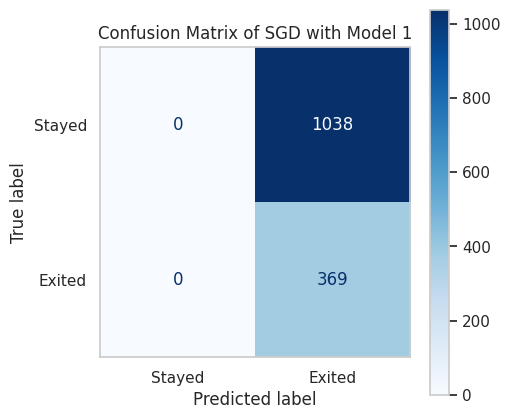

SGD | Model 1
Precision Score: 26.00 %
Recall Score:    100.00 %
F1 Score:        42.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 73.4186


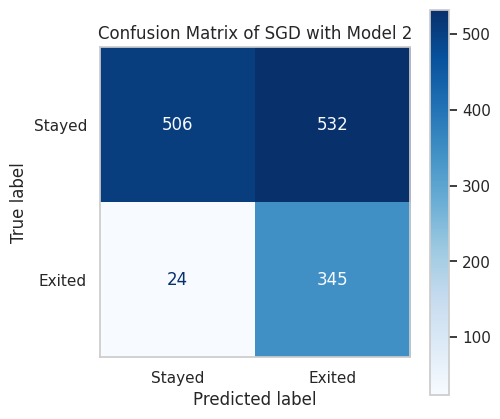

SGD | Model 2
Precision Score: 39.00 %
Recall Score:    93.00 %
F1 Score:        55.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Best accuracy: 73.0633


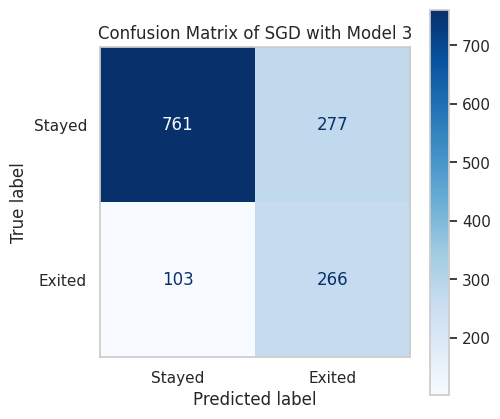

SGD | Model 3
Precision Score: 49.00 %
Recall Score:    72.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 192 | no improvement in last 100 epochs.

 Best accuracy: 74.7690


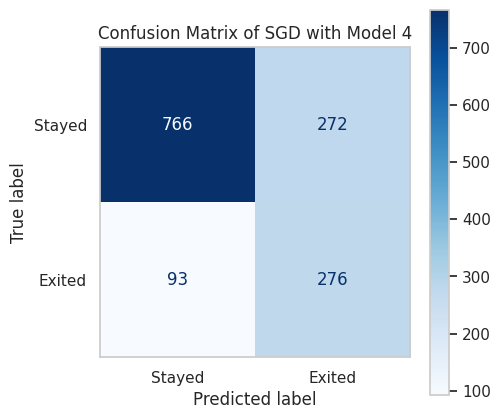

SGD | Model 4
Precision Score: 50.00 %
Recall Score:    75.00 %
F1 Score:        60.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 76.4037


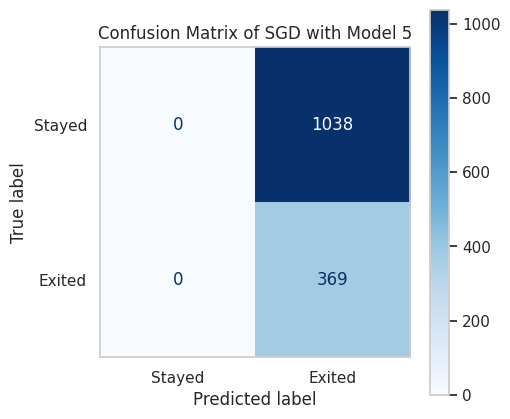

SGD | Model 5
Precision Score: 26.00 %
Recall Score:    100.00 %
F1 Score:        42.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 212 | no improvement in last 100 epochs.

 Best accuracy: 72.5657


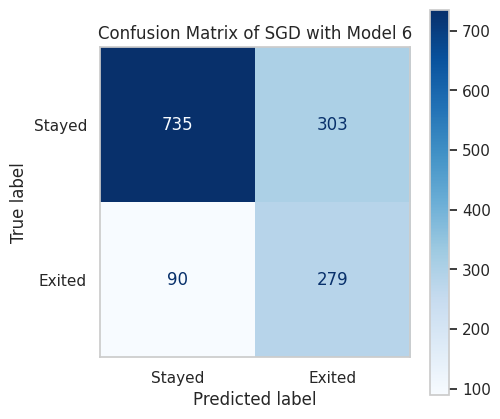

SGD | Model 6
Precision Score: 48.00 %
Recall Score:    76.00 %
F1 Score:        59.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 73.7740


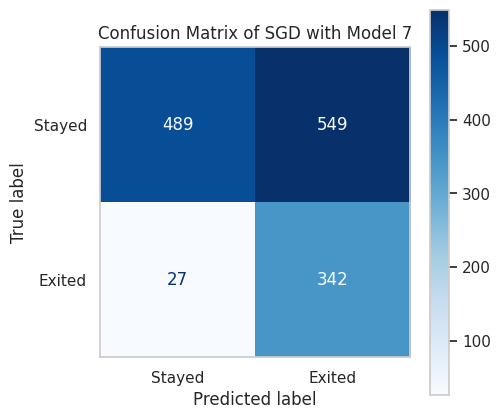

SGD | Model 7
Precision Score: 38.00 %
Recall Score:    93.00 %
F1 Score:        54.00 %


In [74]:
run_all_models(SGD_optim_dict, loss_fns, 'SGD', SGD_accuracy_scores, SGD_precision_scores, SGD_recall_scores, SGD_f1_scores)

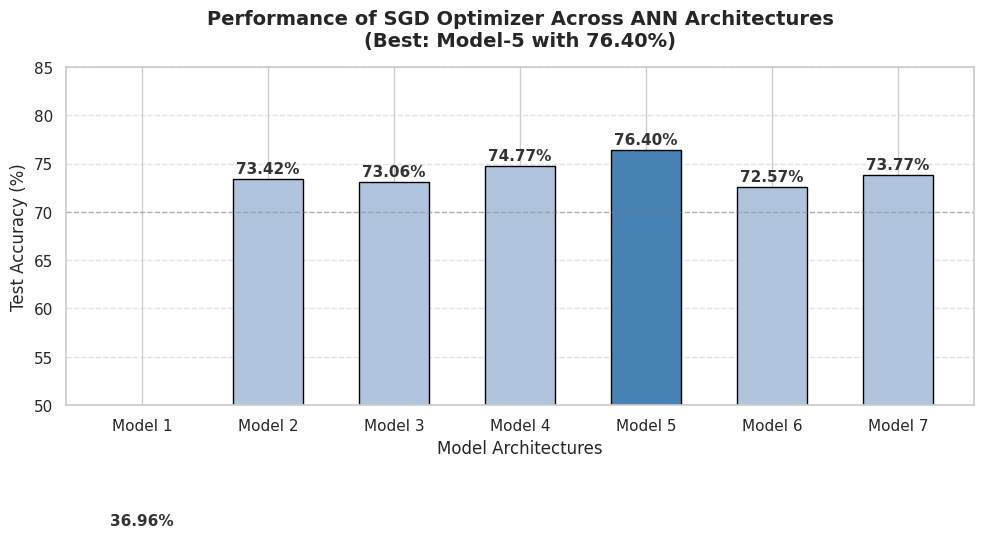

In [75]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
accuracy_plot(models, SGD_accuracy_scores, optimizer='SGD')

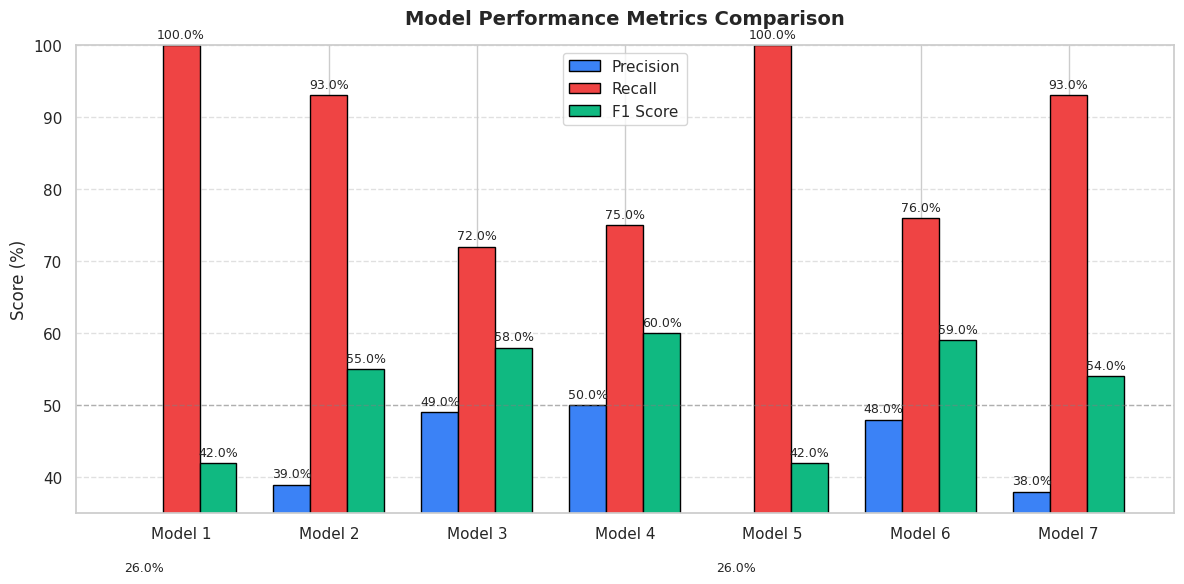

In [76]:
plot_metrics_grouped(models, SGD_precision_scores, SGD_recall_scores, SGD_f1_scores)

# Adaptive moment estimator (Adam)

______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 155 | no improvement in last 100 epochs.

 Best accuracy: 64.8898


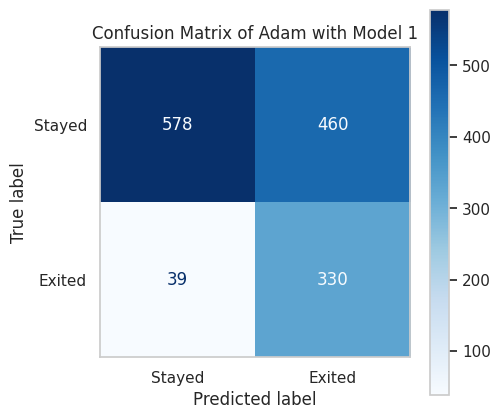

Adam | Model 1
Precision Score: 42.00 %
Recall Score:    89.00 %
F1 Score:        57.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Best accuracy: 66.3824


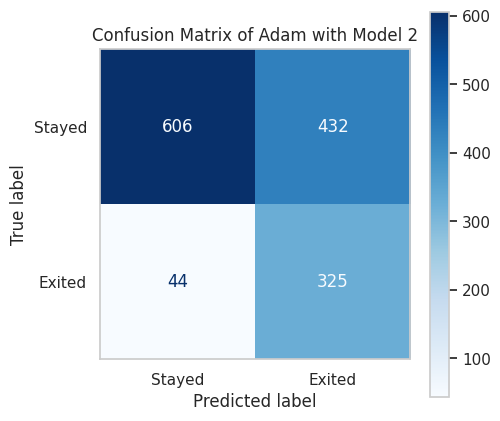

Adam | Model 2
Precision Score: 43.00 %
Recall Score:    88.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 193 | no improvement in last 100 epochs.

 Best accuracy: 75.6219


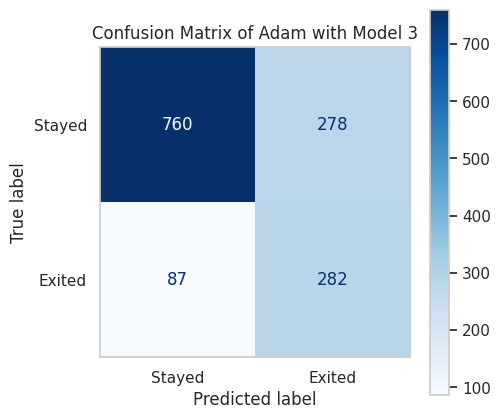

Adam | Model 3
Precision Score: 50.00 %
Recall Score:    76.00 %
F1 Score:        61.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 119 | no improvement in last 100 epochs.

 Best accuracy: 75.1955


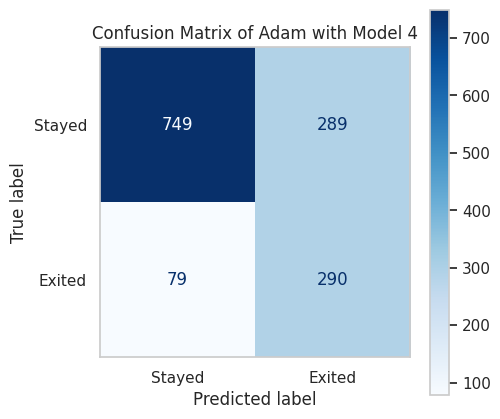

Adam | Model 4
Precision Score: 50.00 %
Recall Score:    79.00 %
F1 Score:        61.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Best accuracy: 66.5956


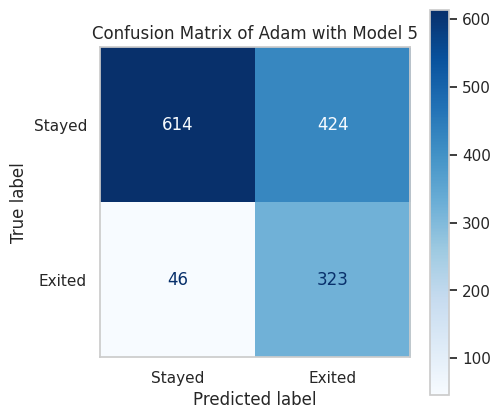

Adam | Model 5
Precision Score: 43.00 %
Recall Score:    88.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 112 | no improvement in last 100 epochs.

 Best accuracy: 73.2054


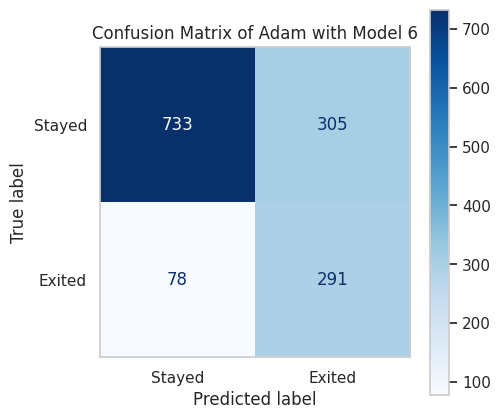

Adam | Model 6
Precision Score: 49.00 %
Recall Score:    79.00 %
F1 Score:        60.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 108 | no improvement in last 100 epochs.

 Best accuracy: 67.3774


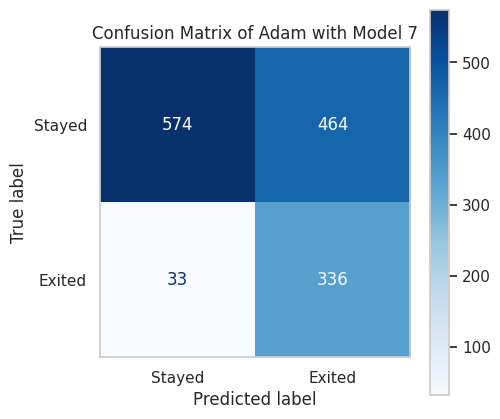

Adam | Model 7
Precision Score: 42.00 %
Recall Score:    91.00 %
F1 Score:        57.00 %


In [77]:
run_all_models(Adam_optim_dict, loss_fns, 'Adam', adam_accuracy_scores, adam_precision_scores, adam_recall_scores, adam_f1_scores)

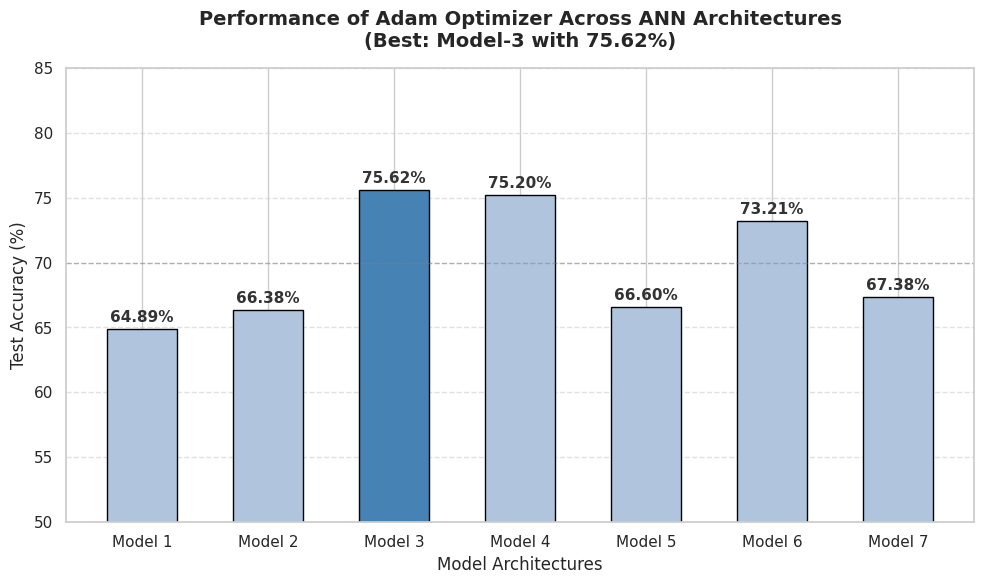

In [78]:
accuracy_plot(models, adam_accuracy_scores, optimizer = 'Adam')

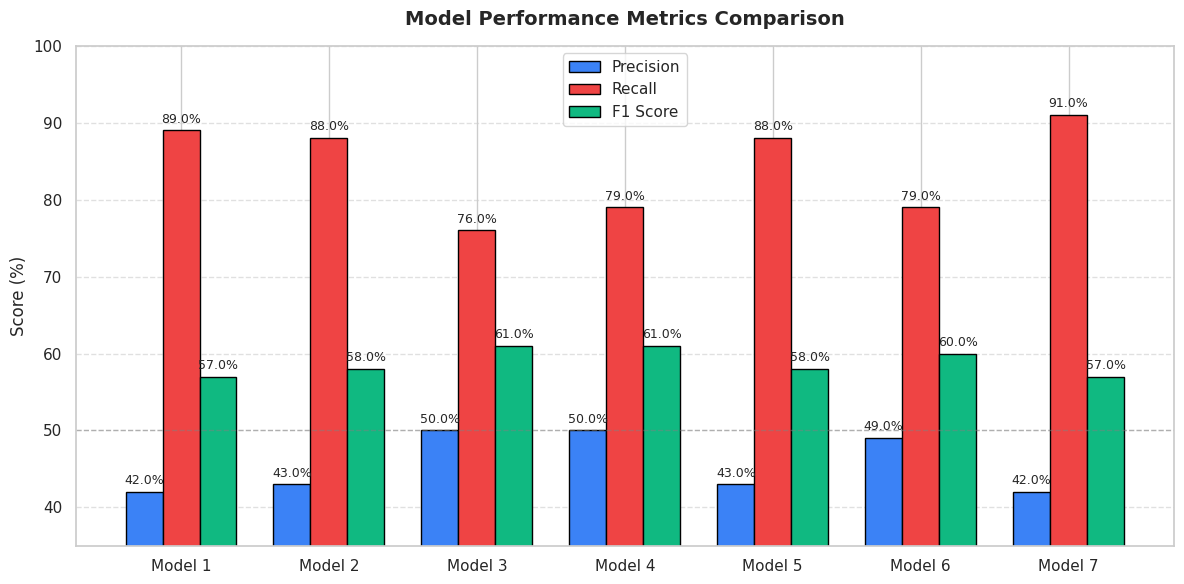

In [79]:
plot_metrics_grouped(models, adam_precision_scores, adam_recall_scores, adam_f1_scores)

# RMSprop

______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 101 | no improvement in last 100 epochs.

 Best accuracy: 76.3326


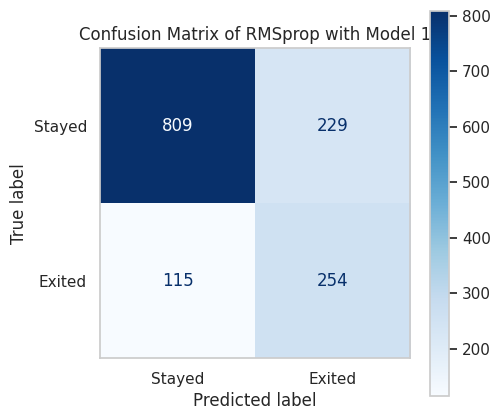

RMSprop | Model 1
Precision Score: 53.00 %
Recall Score:    69.00 %
F1 Score:        60.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Best accuracy: 74.6269


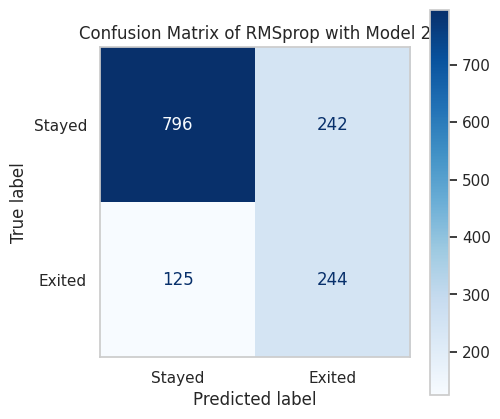

RMSprop | Model 2
Precision Score: 50.00 %
Recall Score:    66.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 101 | no improvement in last 100 epochs.

 Best accuracy: 77.7541


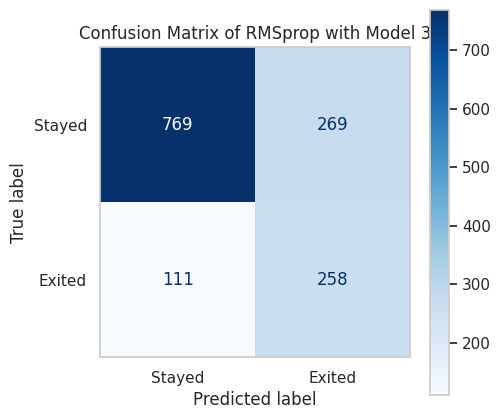

RMSprop | Model 3
Precision Score: 49.00 %
Recall Score:    70.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 118 | no improvement in last 100 epochs.

 Best accuracy: 77.4698


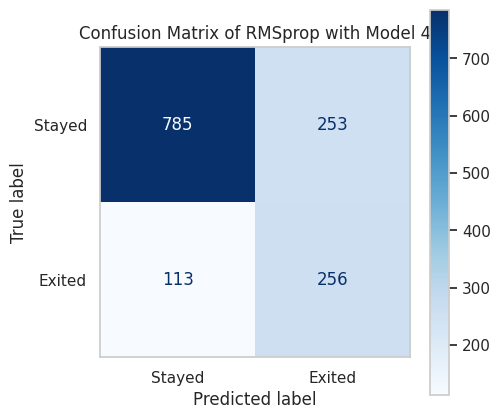

RMSprop | Model 4
Precision Score: 50.00 %
Recall Score:    69.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 104 | no improvement in last 100 epochs.

 Best accuracy: 77.1144


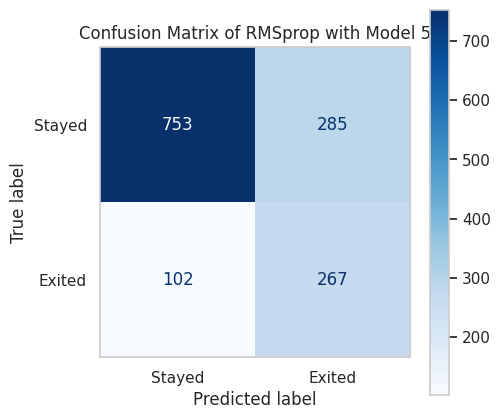

RMSprop | Model 5
Precision Score: 48.00 %
Recall Score:    72.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 116 | no improvement in last 100 epochs.

 Best accuracy: 76.4037


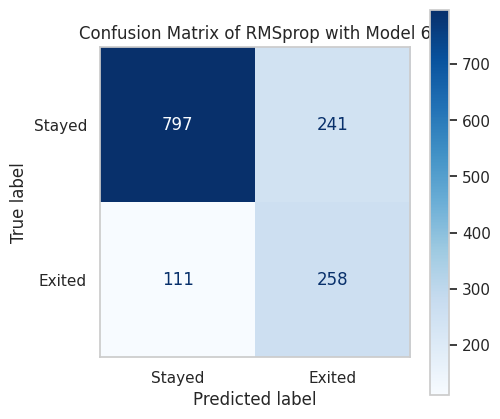

RMSprop | Model 6
Precision Score: 52.00 %
Recall Score:    70.00 %
F1 Score:        59.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 116 | no improvement in last 100 epochs.

 Best accuracy: 71.2864


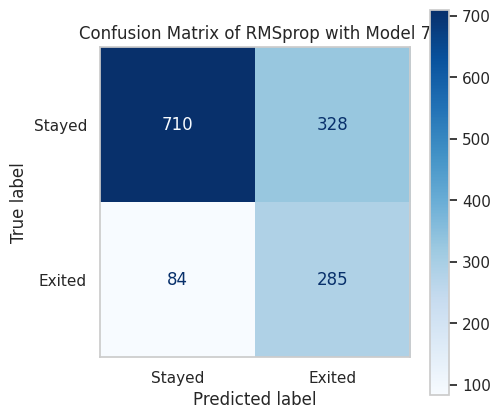

RMSprop | Model 7
Precision Score: 46.00 %
Recall Score:    77.00 %
F1 Score:        58.00 %


In [80]:
run_all_models(RMSprop_optim_dict, loss_fns, 'RMSprop', rms_accuracy_scores, rms_precision_scores, rms_recall_scores, rms_f1_scores)

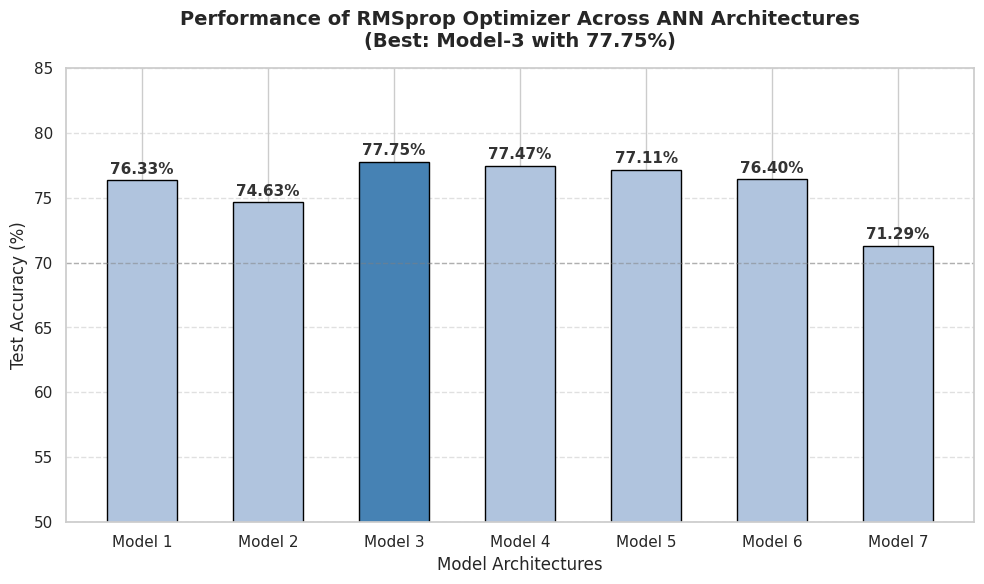

In [81]:
accuracy_plot(models, rms_accuracy_scores, optimizer = 'RMSprop')

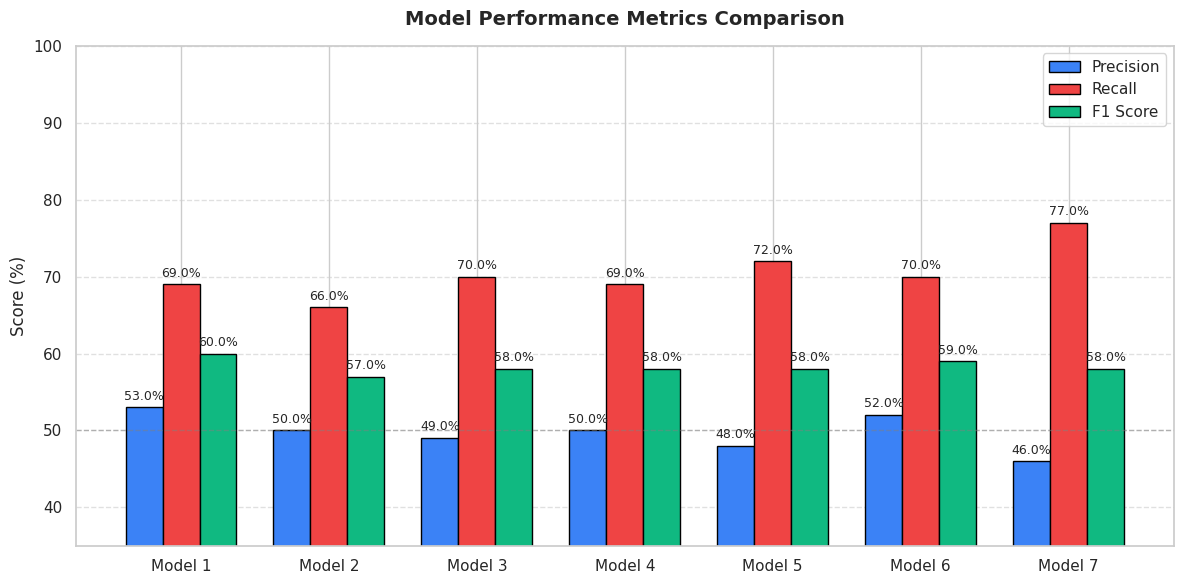

In [82]:
plot_metrics_grouped(models, rms_precision_scores, rms_recall_scores, rms_f1_scores)

# SGD with Momentum


______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 74.7690


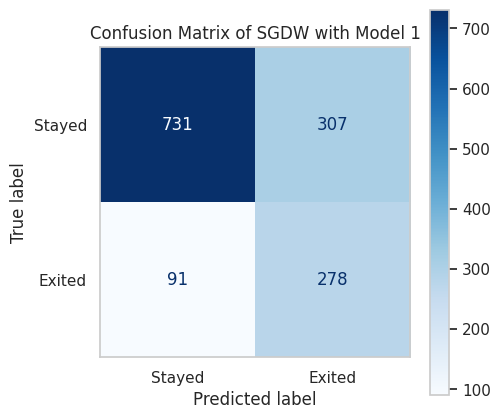

SGDW | Model 1
Precision Score: 48.00 %
Recall Score:    75.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 102 | no improvement in last 100 epochs.

 Best accuracy: 73.7029


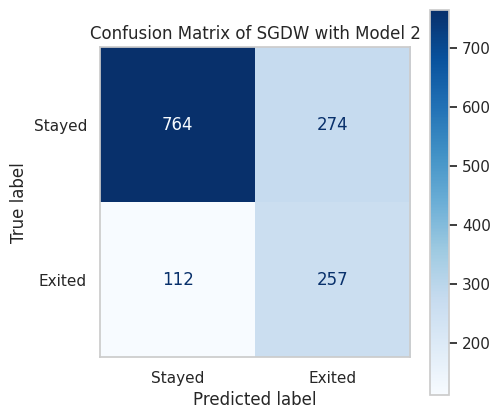

SGDW | Model 2
Precision Score: 48.00 %
Recall Score:    70.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 111 | no improvement in last 100 epochs.

 Best accuracy: 75.9773


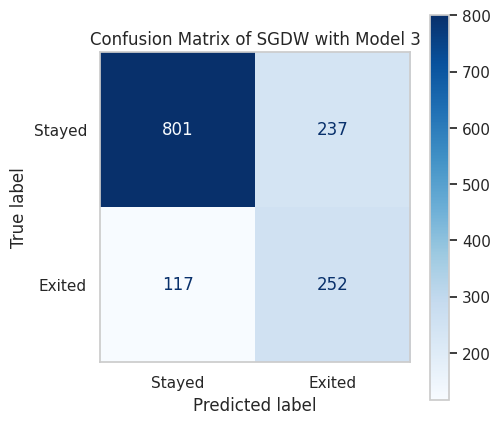

SGDW | Model 3
Precision Score: 52.00 %
Recall Score:    68.00 %
F1 Score:        59.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 221 | no improvement in last 100 epochs.

 Best accuracy: 74.6979


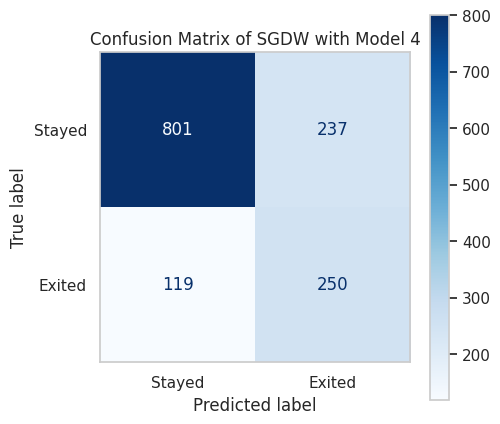

SGDW | Model 4
Precision Score: 51.00 %
Recall Score:    68.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 72.2814


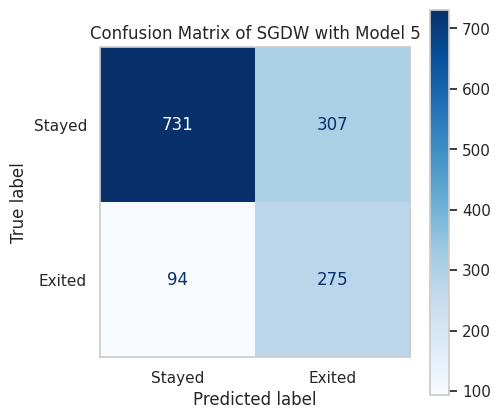

SGDW | Model 5
Precision Score: 47.00 %
Recall Score:    75.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 100 | no improvement in last 100 epochs.

 Best accuracy: 75.0533


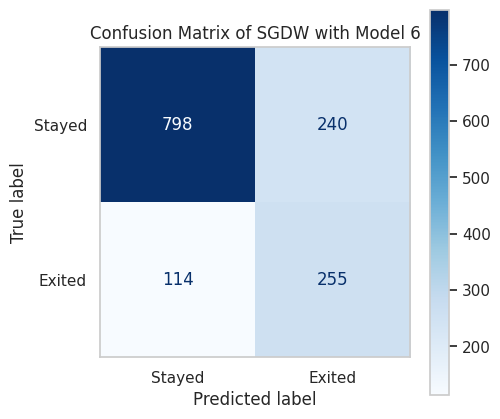

SGDW | Model 6
Precision Score: 52.00 %
Recall Score:    69.00 %
F1 Score:        59.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 217 | no improvement in last 100 epochs.

 Best accuracy: 70.7889


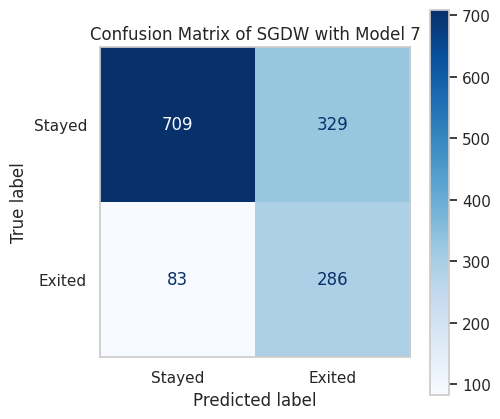

SGDW | Model 7
Precision Score: 47.00 %
Recall Score:    78.00 %
F1 Score:        58.00 %


In [83]:
run_all_models(SGDW_optim_dict, loss_fns, 'SGDW', SGDW_accuracy_scores, SGDW_precision_scores, SGDW_recall_scores, SGDW_f1_scores)

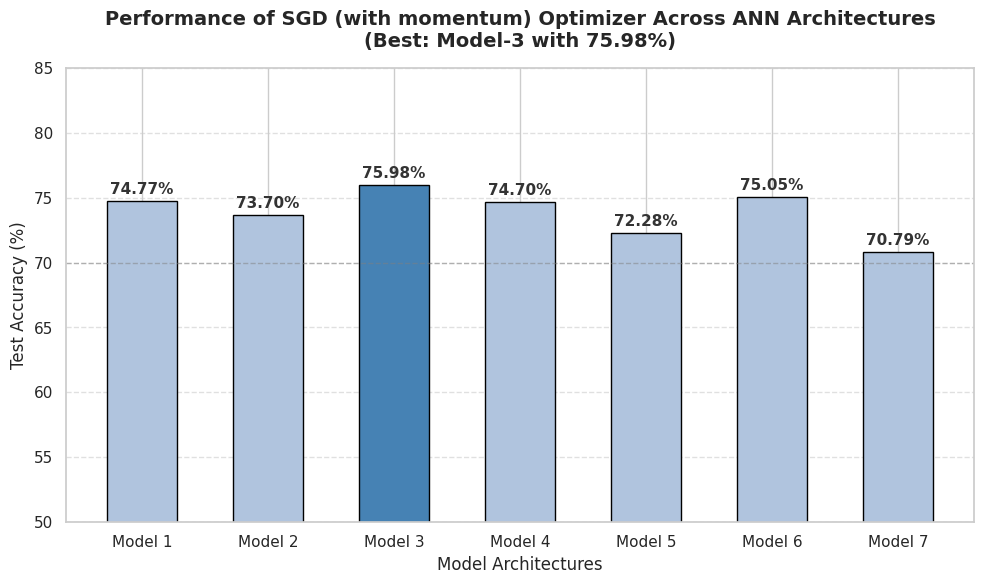

In [84]:
accuracy_plot(models, SGDW_accuracy_scores, optimizer = 'SGD (with momentum)')

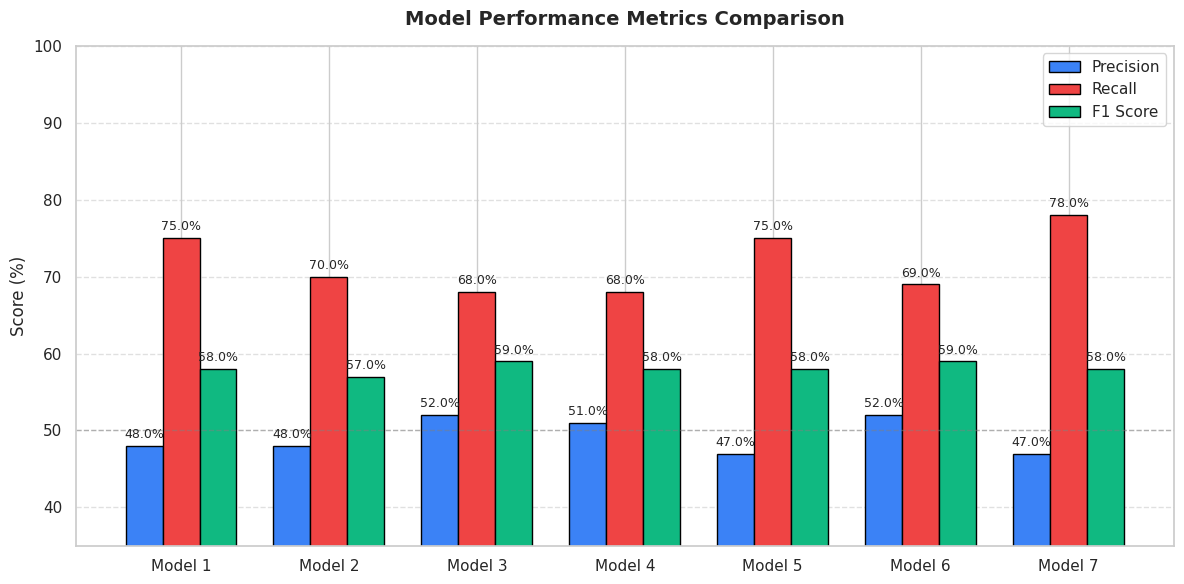

In [85]:
plot_metrics_grouped(models, SGDW_precision_scores, SGDW_recall_scores, SGDW_f1_scores)

# AdaGrad

______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 129 | no improvement in last 100 epochs.

 Best accuracy: 78.7491


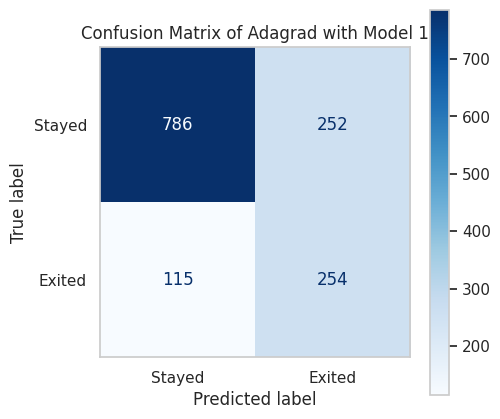

Adagrad | Model 1
Precision Score: 50.00 %
Recall Score:    69.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 101 | no improvement in last 100 epochs.

 Best accuracy: 73.7029


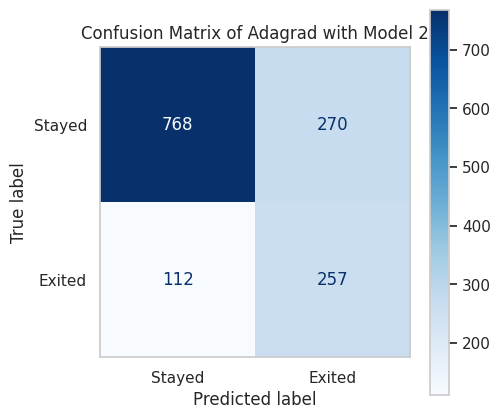

Adagrad | Model 2
Precision Score: 49.00 %
Recall Score:    70.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 115 | no improvement in last 100 epochs.

 Best accuracy: 79.3888


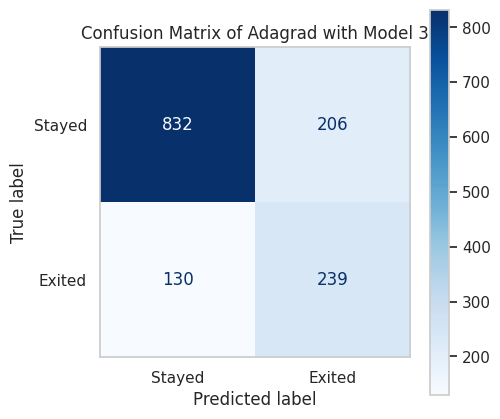

Adagrad | Model 3
Precision Score: 54.00 %
Recall Score:    65.00 %
F1 Score:        59.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 102 | no improvement in last 100 epochs.

 Best accuracy: 76.7591


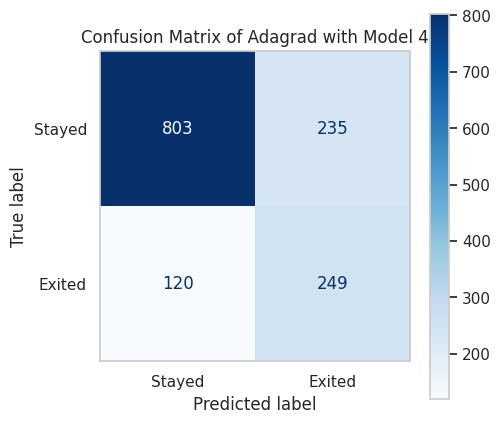

Adagrad | Model 4
Precision Score: 51.00 %
Recall Score:    67.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 105 | no improvement in last 100 epochs.

 Best accuracy: 76.4748


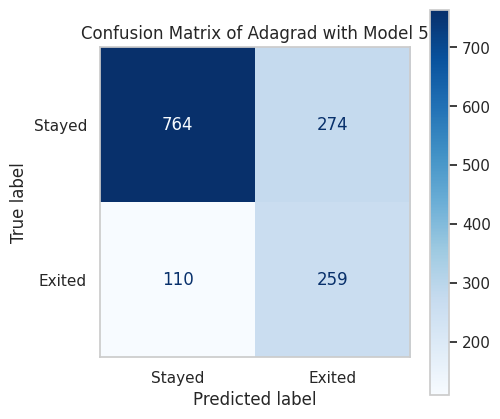

Adagrad | Model 5
Precision Score: 49.00 %
Recall Score:    70.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 102 | no improvement in last 100 epochs.

 Best accuracy: 76.0483


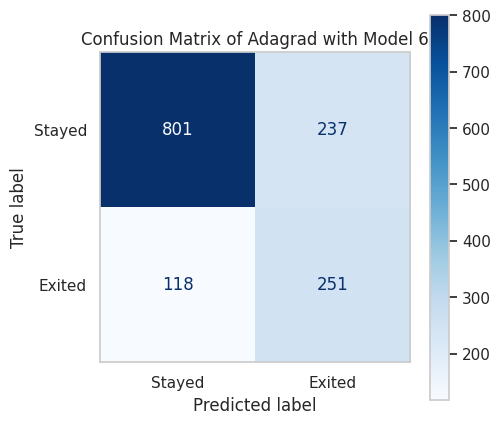

Adagrad | Model 6
Precision Score: 51.00 %
Recall Score:    68.00 %
F1 Score:        59.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 102 | no improvement in last 100 epochs.

 Best accuracy: 74.1294


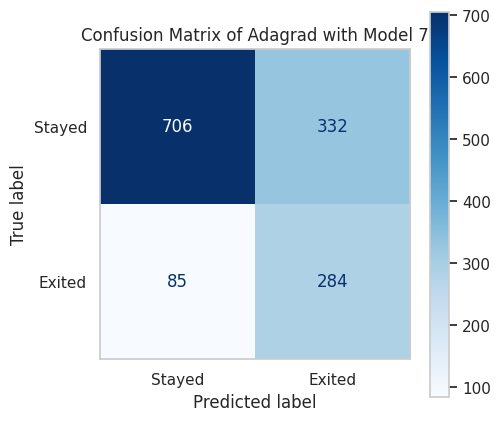

Adagrad | Model 7
Precision Score: 46.00 %
Recall Score:    77.00 %
F1 Score:        58.00 %


In [86]:
run_all_models(Adagrad_optim_dict, loss_fns, 'Adagrad', adagrad_accuracy_scores, adagrad_precision_scores, adagrad_recall_scores, adagrad_f1_scores, matrix = True)

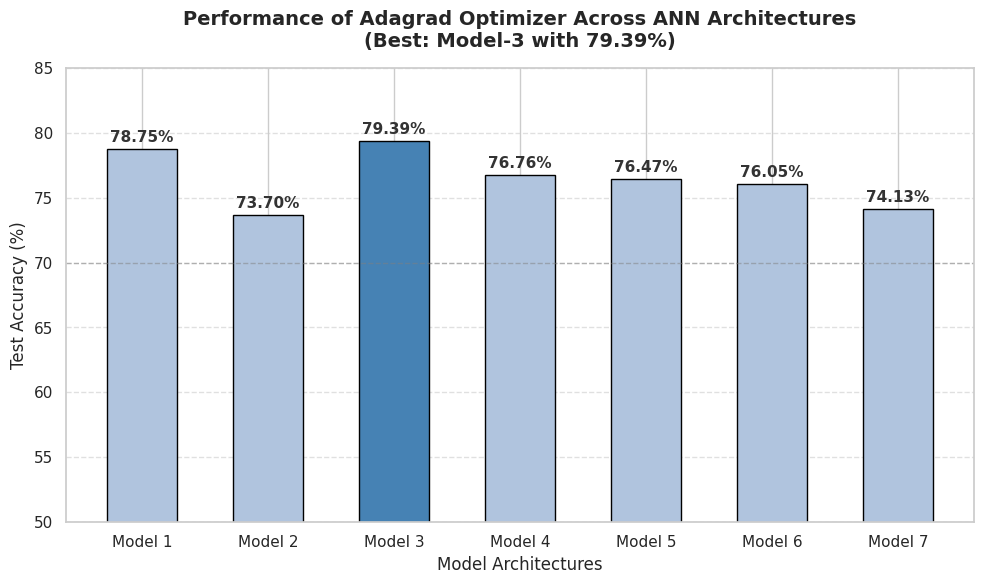

In [87]:
accuracy_plot(models, adagrad_accuracy_scores, optimizer = 'Adagrad')

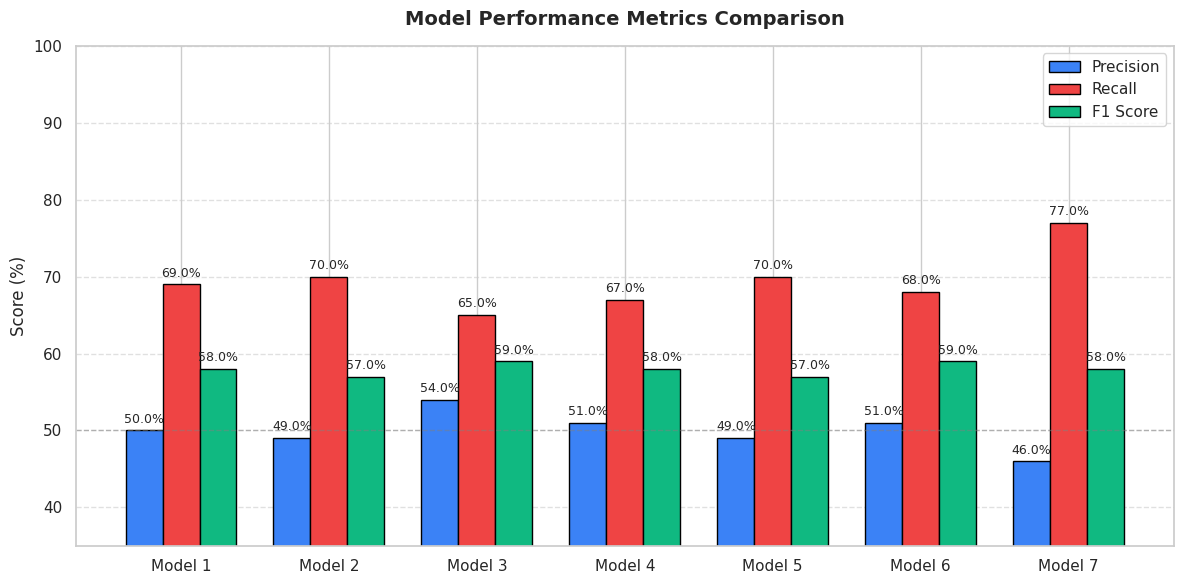

In [88]:
plot_metrics_grouped(models, adagrad_precision_scores, adagrad_recall_scores, adagrad_f1_scores)

# Adam with Momentum

______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 105 | no improvement in last 100 epochs.

 Best accuracy: 73.0633


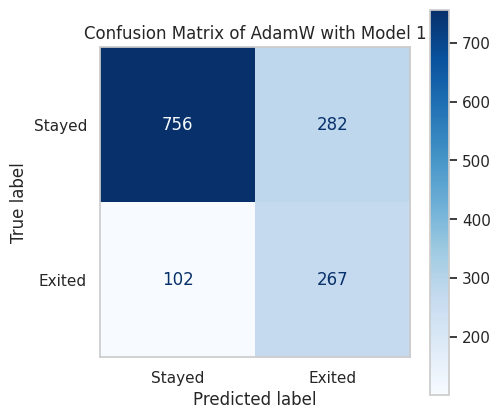

AdamW | Model 1
Precision Score: 49.00 %
Recall Score:    72.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Best accuracy: 74.2715


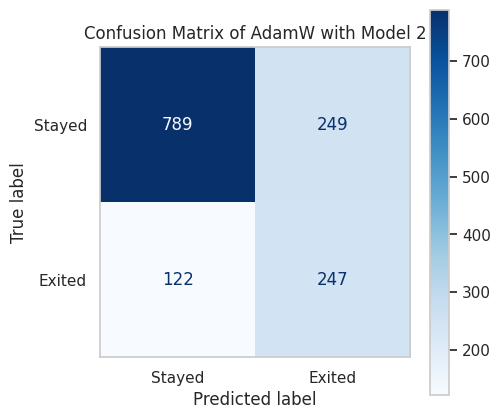

AdamW | Model 2
Precision Score: 50.00 %
Recall Score:    67.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 103 | no improvement in last 100 epochs.

 Best accuracy: 77.1144


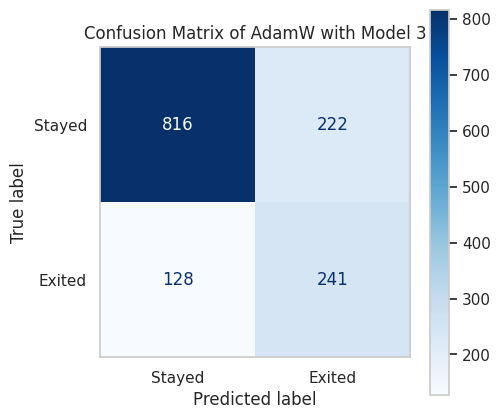

AdamW | Model 3
Precision Score: 52.00 %
Recall Score:    65.00 %
F1 Score:        58.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 178 | no improvement in last 100 epochs.

 Best accuracy: 75.0533


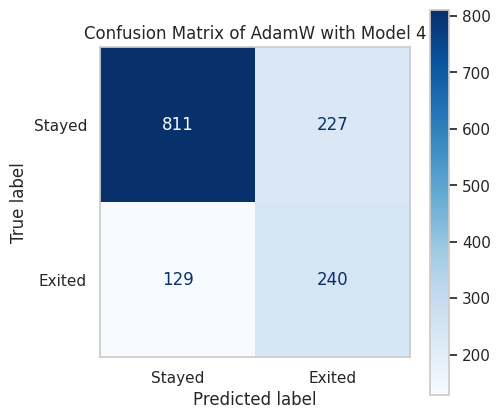

AdamW | Model 4
Precision Score: 51.00 %
Recall Score:    65.00 %
F1 Score:        57.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 104 | no improvement in last 100 epochs.

 Best accuracy: 72.7079


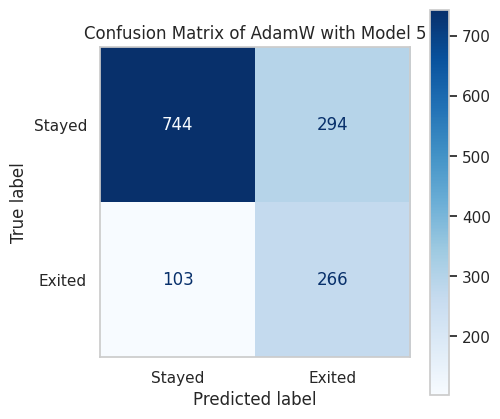

AdamW | Model 5
Precision Score: 47.00 %
Recall Score:    72.00 %
F1 Score:        57.00 %
________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 241 | no improvement in last 100 epochs.

 Best accuracy: 75.4087


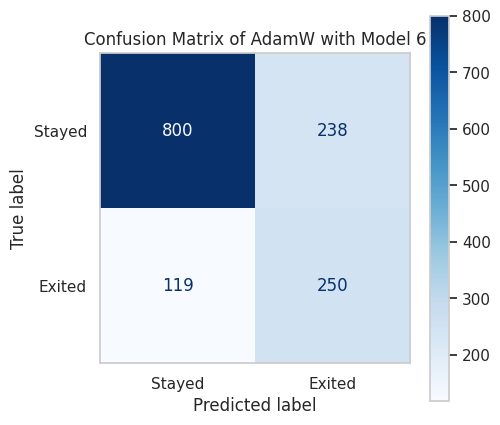

AdamW | Model 6
Precision Score: 51.00 %
Recall Score:    68.00 %
F1 Score:        58.00 %
______________________________________________________________________________________________________________________________________________________________________________________

 Early stopping at epoch 189 | no improvement in last 100 epochs.

 Best accuracy: 71.6418


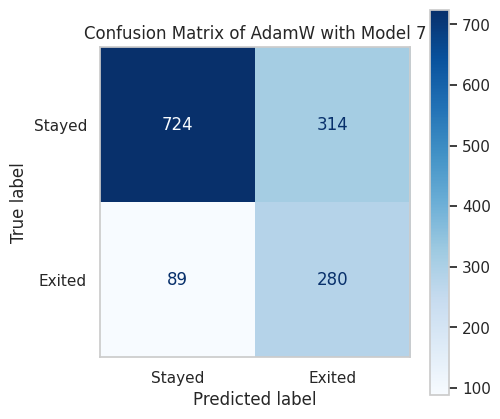

AdamW | Model 7
Precision Score: 47.00 %
Recall Score:    76.00 %
F1 Score:        58.00 %


In [89]:
run_all_models(AdamW_optim_dict, loss_fns, 'AdamW', adamW_accuracy_scores, adamW_precision_scores, adamW_recall_scores, adamW_f1_scores)

In [90]:
def plot_top_n_roc_curves(roc_curve_data, top_n=5):
    sorted_data = sorted(roc_curve_data, key=lambda x: x["auc"], reverse=True)[:top_n]

    plt.figure(figsize=(10, 7))
    for entry in sorted_data:
        label = f'{entry["model"]} ({entry["optimizer"]}) - AUC: {entry["auc"]:.2f}'
        plt.plot(entry["fpr"], entry["tpr"], label=label)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f"Top {top_n} Models - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


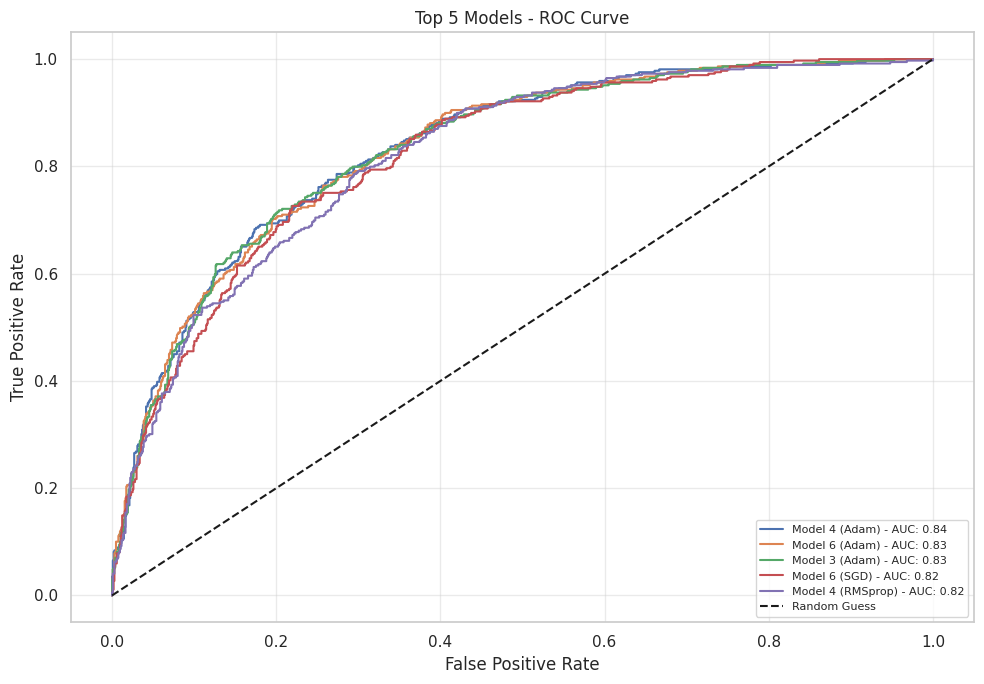

In [91]:
plot_top_n_roc_curves(roc_curve_data, top_n=5)

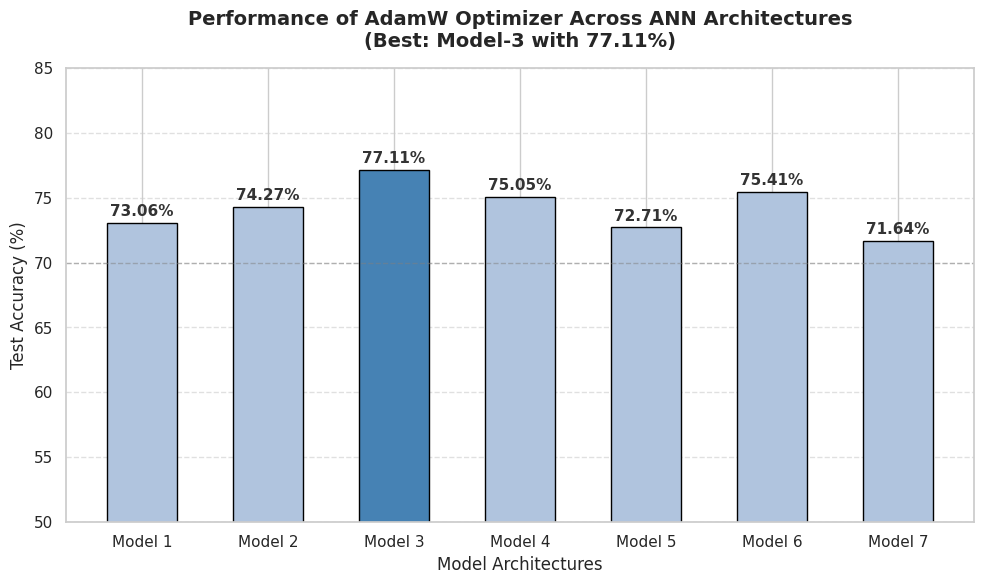

In [92]:
accuracy_plot(models, adamW_accuracy_scores, optimizer='AdamW')

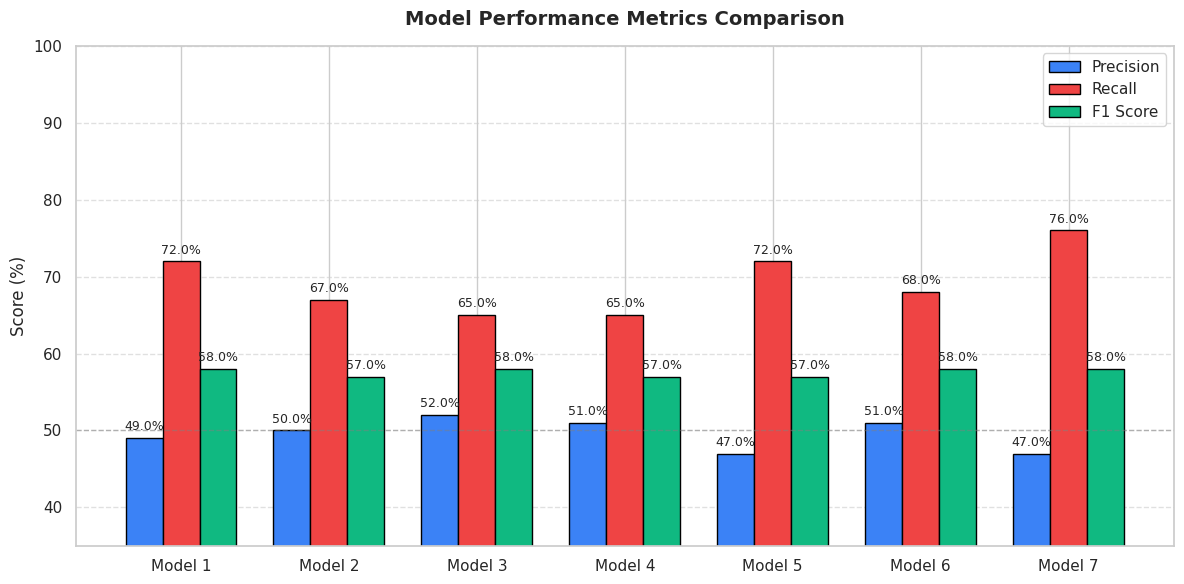

In [93]:
plot_metrics_grouped(models, adamW_precision_scores, adamW_recall_scores, adamW_f1_scores)

# Summary Table

In [94]:
summary = {
    "Model": [f"Model {i+1}" for i in range(7)] * 6,
    "Optimizer": (["SGD"] * 7 +
                  ["Adam"] * 7 +
                  ["RMSProp"] * 7 +
                  ["SGD+W"] * 7 +
                  ["Adagrad"] * 7 +
                  ["AdamW"] * 7),
    "Accuracy": SGD_accuracy_scores + adam_accuracy_scores + rms_accuracy_scores + SGDW_accuracy_scores + adagrad_accuracy_scores + adamW_accuracy_scores,
    "Precision": SGD_precision_scores + adam_precision_scores + rms_precision_scores + SGDW_precision_scores + adagrad_precision_scores + adamW_precision_scores,
    "Recall": SGD_recall_scores + adam_recall_scores + rms_recall_scores + SGDW_recall_scores + adagrad_recall_scores + adamW_recall_scores,
    "F1 Score": SGD_f1_scores + adam_f1_scores + rms_f1_scores + SGDW_f1_scores + adagrad_f1_scores + adamW_f1_scores
}

df = pd.DataFrame(summary)
df = df.round(2)
df

,Model,Optimizer,Accuracy,Precision,Recall,F1 Score
0,Model 1,SGD,36.96,26.0,100.0,42.0
1,Model 2,SGD,73.42,39.0,93.0,55.0
2,Model 3,SGD,73.06,49.0,72.0,58.0
3,Model 4,SGD,74.77,50.0,75.0,60.0
4,Model 5,SGD,76.40,26.0,100.0,42.0
5,Model 6,SGD,72.57,48.0,76.0,59.0
6,Model 7,SGD,73.77,38.0,93.0,54.0
7,Model 1,Adam,64.89,42.0,89.0,57.0
8,Model 2,Adam,66.38,43.0,88.0,58.0
9,Model 3,Adam,75.62,50.0,76.0,61.0


In [95]:
# @title
def plot_selected_roc_curves(roc_curve_data, selected_models):
    plt.figure(figsize=(10, 7))

    for entry in roc_curve_data:
        model = entry.get("model", "").strip()
        optimizer = entry.get("optimizer", "").strip().lower()
        label_id = f"{optimizer}_model_{model.split()[-1]}"

        if label_id in selected_models:
            label = f'{model} + {optimizer.title()} (AUC: {entry["auc"]:.2f})'
            plt.plot(entry["fpr"], entry["tpr"], label=label)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title("Selected ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Machine Learning Models

* KNN is said to be very redundant with tabular data
* Skipping Decision tress? Maybe
* Gausian NB? exceeded my expectations


In [97]:
Logistic_regression = LogisticRegression()
SV_classifier = SVC(kernel = 'linear', random_state = 0)
SV_machine = SVC(kernel = 'rbf', random_state = 0)
Random_forest = RandomForestClassifier(n_estimators = 20, criterion='entropy', random_state = 0)
bayes = GaussianNB()
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p = 2)
tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

In [98]:
models = [Logistic_regression, SV_classifier, SV_machine, Random_forest, xgb_classifier, bayes, knn, tree]
model_names = ['Logistic\nRegression', 'SVC\n(Linear)', 'SVC\n(RBF)', 'Random\nForest', 'XGboost', 'Naive\nBayes', 'KNN', 'Decision\nTrees']

accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

y_train = y_train.ravel()
y_test = y_test.ravel()

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prss = round(precision_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    recs = round(recall_score(y_test, y_pred) * 100, 2)

    accuracy_scores.append(acc)
    precision_scores.append(prss)
    recall_scores.append(recs)
    f1_scores.append(f1)

    print('\n',cm)


 [[752 286]
 [ 71 298]]

 [[727 311]
 [ 66 303]]

 [[771 267]
 [ 93 276]]

 [[895 143]
 [163 206]]

 [[885 153]
 [151 218]]

 [[729 309]
 [ 72 297]]

 [[718 320]
 [102 267]]

 [[822 216]
 [171 198]]


# Tuning the ML models

In [99]:
# @title
def tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train.ravel())

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prss = round(precision_score(y_test, y_pred) * 100, 2)
    recs = round(recall_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    cm = confusion_matrix(y_test, y_pred)

    return {
        "Model": type(best_model).__name__,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prss,
        "Recall": recs,
        "F1 Score": f1,
        "Confusion Matrix": cm
    }

In [100]:
models_and_params = [
    (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }),
    (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [10, 20]
    }),
    (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }),
    (xgb.XGBClassifier(eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'max_depth': [3, 10, 20]
    }),
    (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }),
]

In [101]:
results = []

for model, param_grid in models_and_params:
    result = tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test)
    results.append(result)

df = pd.DataFrame(results)


# Metric Visualization

In [102]:
# @title
def metric_plot(models, metric_values, metric_name, ylim_1, ylim_2, baseline=None):
    best_idx = metric_values.index(max(metric_values))
    bar_colors = ['#B0C4DE' if i != best_idx else '#4682B4' for i in range(len(models))]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(models, metric_values, color=bar_colors, edgecolor='black', width=0.55)

    # Annotate bars with metric values
    for bar, val in zip(bars, metric_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            val + 0.3,
            f"{val:.2f}%",
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='semibold',
            color='#333333')

    # Baseline reference line if provided
    if baseline is not None:
        plt.axhline(y=baseline, color='grey', linestyle='--', linewidth=1, alpha=0.5)

    plt.title(
        f'{metric_name} Across Models\n(Best: {models[best_idx]} with {metric_values[best_idx]:.2f}%)',
        fontsize=14,
        fontweight='bold',
        pad=15)

    plt.xlabel('Models', fontsize=12)
    plt.ylabel(f'{metric_name} (%)', fontsize=12)
    plt.ylim(ylim_1, ylim_2)
    plt.xticks(rotation=0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

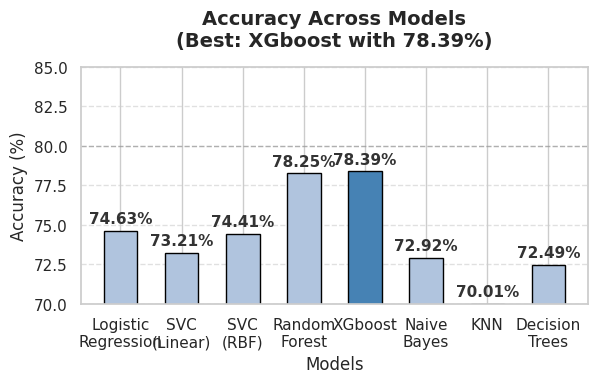

In [103]:
# @title
metric_plot(model_names, accuracy_scores, 'Accuracy', 70, 85, baseline = 80)

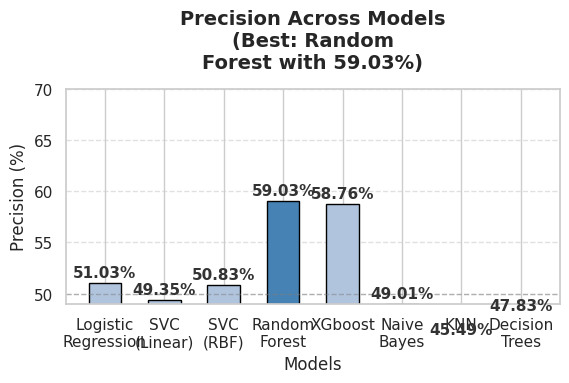

In [104]:
# @title
metric_plot(model_names, precision_scores, 'Precision', 49, 70, baseline=50)

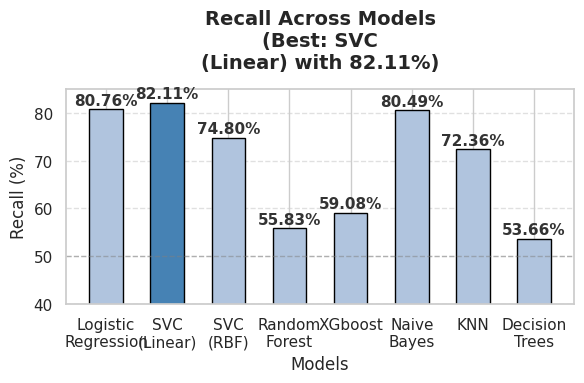

In [105]:
# @title
metric_plot(model_names, recall_scores, 'Recall', 40, 85, baseline=50)

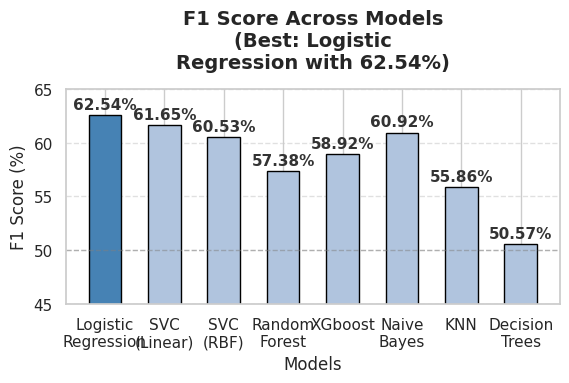

In [106]:
# @title
metric_plot(model_names, f1_scores, 'F1 Score', 45, 65, baseline=50)

# Tuned Performance Scores and Visualization

In [107]:
df

,Model,Best Params,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,"{'C': 0.1, 'solver': 'liblinear'}",75.20,51.73,81.03,63.15,"[[759, 279], [70, 299]]"
1,SVC,"{'C': 10, 'kernel': 'rbf'}",74.27,50.73,66.12,57.41,"[[801, 237], [125, 244]]"
2,RandomForestClassifier,"{'max_depth': 20, 'n_estimators': 50}",77.61,57.18,58.27,57.72,"[[877, 161], [154, 215]]"
3,GaussianNB,{'var_smoothing': 1e-09},72.92,49.01,80.49,60.92,"[[729, 309], [72, 297]]"
4,XGBClassifier,"{'max_depth': 20, 'n_estimators': 50}",77.19,56.94,53.39,55.10,"[[889, 149], [172, 197]]"
5,KNeighborsClassifier,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",72.42,47.87,57.99,52.45,"[[805, 233], [155, 214]]"
6,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 10, 'min...",74.27,50.74,65.31,57.11,"[[804, 234], [128, 241]]"


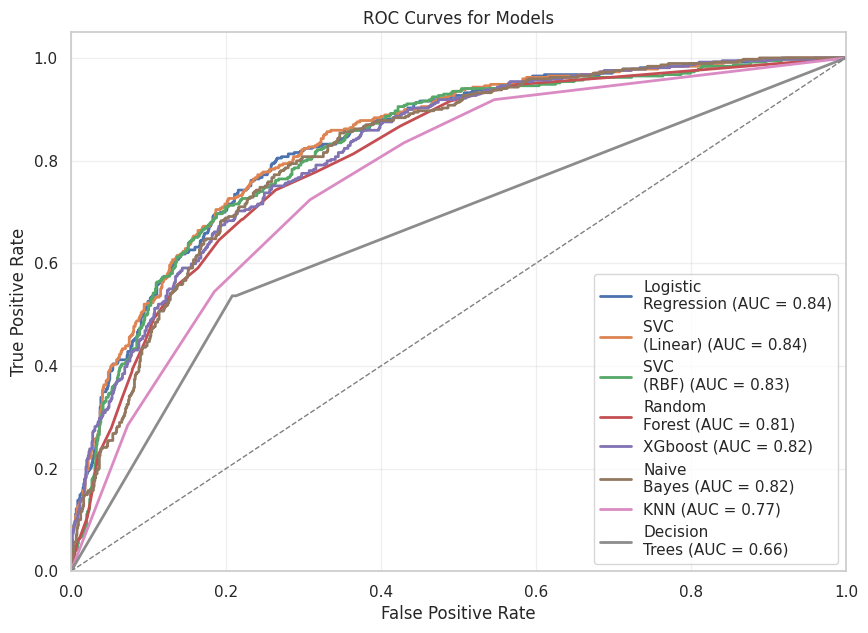

In [108]:
# @title
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 7))

for model, name in zip(models, model_names):

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

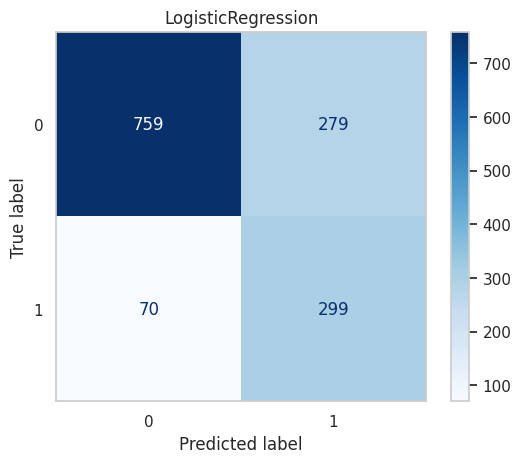

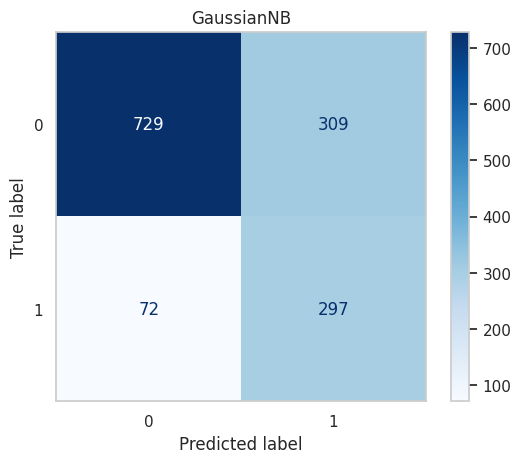

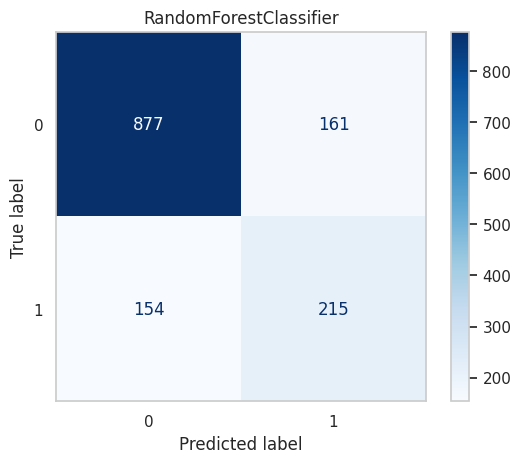

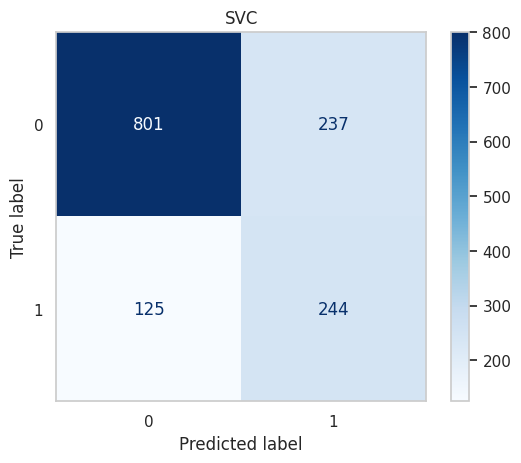

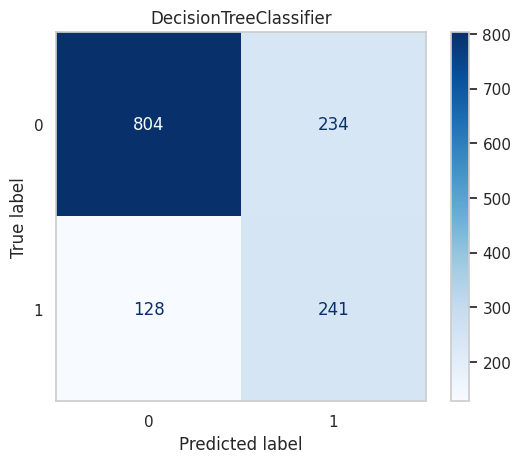

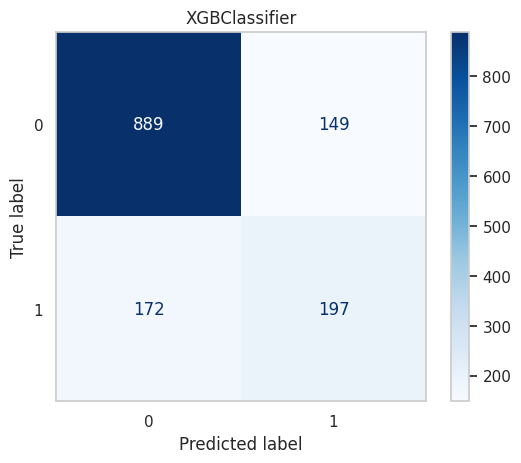

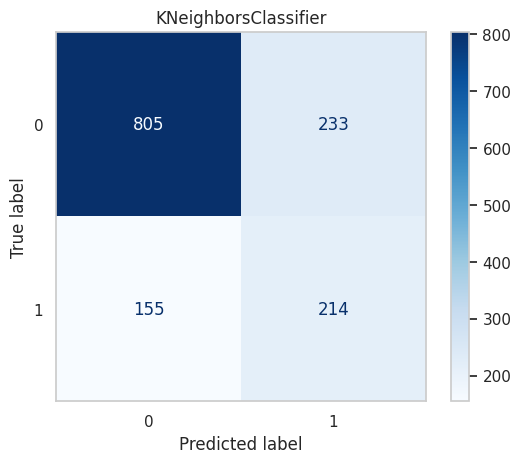

In [109]:
conf_matrices = df["Confusion Matrix"]
df = df.drop(columns=["Confusion Matrix"])
top_models = df.sort_values(by="F1 Score", ascending=False)
for idx in top_models.index:
    row = top_models.loc[idx]
    cm = conf_matrices[idx]
    model_name = row["Model"]
    params = row["Best Params"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name}")
    plt.grid(False)
    plt.show()